In [1]:
%matplotlib notebook

In [2]:
import subprocess as sp
from subprocess import call
import pysam as ps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import shutil
from os import remove, getcwd, makedirs
from os.path import join, exists, dirname
from matplotlib.ticker import FormatStrFormatter

In [3]:
notebook_dir = getcwd()

rtg_bin = '/Users/dcooke/Genomics/apps/rtg-tools/rtg'
rtg_ref = '/Users/dcooke/Genomics/references/human/GRCh37_SDF'

somatic_dir = dirname(notebook_dir)
paper_dir = dirname(somatic_dir)

truth_dir = join(somatic_dir, "truth")

call_dir = join(notebook_dir, "calls")
eval_dir = join(notebook_dir, "eval")

callers = ['Octopus', 'Mutect2', 'Strelka2', 'Lancet', 'LoFreq', 'VarDict', 'Platypus']

tumour_types = ['skin', 'breast']

depths = {
    'normal': [15, 20, 30, 35],
    'skin': [30, 45, 60],
    'breast': [40, 65]
}

truth_vcfs = {
    'skin': join(truth_dir, "skin.vcf.gz"),
    'breast': join(truth_dir, "breast.vcf.gz")
}

evaluation_beds = {
    'skin': {
        'chromosomes': join(paper_dir, 'misc/hs37d5.chromosomes.bed'),
        'autosomes': join(paper_dir, 'misc/hs37d5.autosomes.bed'),
        'test': join(truth_dir, 'skin.bed')
    },
    'breast': {
        'chromosomes': join(paper_dir, 'misc/hs37d5.chromosomes.bed'),
        'test': join(truth_dir, 'breast.bed')
    }
}

caller_score_metric = {
    'Octopus': 'FORMAT.RFQUAL',
    'Mutect2': 'INFO.TLOD',
    'Strelka2': 'INFO.SomaticEVS',
    'Platypus': 'QUAL',
    'LoFreq': 'QUAL',
    'Lancet': 'QUAL',
    'VarDict': 'INFO.SSF'
}

caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'Mutect2': sns.xkcd_rgb["pale red"],
    'Strelka2': sns.xkcd_rgb["amber"],
    'Platypus': sns.xkcd_rgb["greyish"],
    'LoFreq': sns.xkcd_rgb["faded green"],
    'Lancet': sns.xkcd_rgb["dusty purple"],
    'VarDict': sns.xkcd_rgb["powder blue"]
}

caller_linestyles = {
    'Octopus': '',
    'Mutect2': (2,2),
    'Strelka2': (2,2),
    'Platypus': (2,2),
    'LoFreq': (2,2),
    'Lancet': (2,2),
    'VarDict': (2,2)
}

sample_names = {
    'skin': {'normal': 'NA12878.NORMAL', 'tumour': 'NA12878.TUMOUR'},
    'breast': {'normal': 'NA12878.NORMAL', 'tumour': 'NA12878.TUMOUR'}
} 

def get_caller_vcf_path(tumour_type, normal_depth, tumour_depth, caller):
    return join(join(join(join(call_dir, tumour_type), 'N' + str(normal_depth)), 'T' + str(tumour_depth)), caller + '.vcf.gz')

def get_eval_dir(tumour_type, normal_depth, tumour_depth, test, caller, include_filtered=False):
    result = join(join(join(join(eval_dir, tumour_type), 'N' + str(normal_depth)), 'T' + str(tumour_depth)), test)
    if include_filtered:
        result = join(result, 'unfiltered')
    else:
        result = join(result, 'pass')
    return join(result, caller)

caller_vcfs = {}
rtg_eval_dirs = {}

for tumour_type in tumour_types:
    caller_vcfs[tumour_type] = {}
    rtg_eval_dirs[tumour_type] = {}
    for normal_depth in depths['normal']:
        for tumour_depth in depths[tumour_type]:
            test_depths = normal_depth,tumour_depth
            rtg_eval_dirs[tumour_type][test_depths] = {}
            for test in evaluation_beds[tumour_type].keys():
                rtg_eval_dirs[tumour_type][test_depths][test] = {'unfiltered': {}, 'pass': {}}
                caller_vcfs[tumour_type][test_depths] = {}
                for caller in callers:
                    caller_vcfs[tumour_type][test_depths][caller] = get_caller_vcf_path(tumour_type, normal_depth, tumour_depth, caller)
                    rtg_eval_dirs[tumour_type][test_depths][test]['unfiltered'][caller] = get_eval_dir(tumour_type, normal_depth, tumour_depth, test, caller, True)
                    rtg_eval_dirs[tumour_type][test_depths][test]['pass'][caller] = get_eval_dir(tumour_type, normal_depth, tumour_depth, test, caller, False)

In [4]:
plt.rcParams['figure.figsize'] = [9, 6]
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
def sum_region_sizes(bed_path):
    res = 0
    with open(bed_path) as bed:
        for line in bed:
            start, end = tuple([int(x) for x in line.strip().split()[1:]])
            res += end - start
    return res

In [6]:
def run_rtg_vcfeval(caller_vcf, truth_vcf, sample, out_dir,
                    score_metric=None, evaluation_regions=None, 
                    include_filtered=False):
    rtg_cmd = [rtg_bin, 'vcfeval', '-t', rtg_ref, '-b', truth_vcf, '-c', caller_vcf, '-o', out_dir,
               '--squash-ploidy', '--sample', sample]
    if evaluation_regions is not None:
        rtg_cmd += ['--bed-regions', evaluation_regions]
    if score_metric is not None:
        rtg_cmd += ['-f', score_metric]
    if include_filtered:
        rtg_cmd.append('--all-records')
    call(rtg_cmd)

def prepare_strelka2_vcf_for_rtg(strelka2_vcf, normal_sample, tumour_sample):
    """"
    Strelka2 does not output a GT field, and renames samples as NORMAL TUMOR.
    """
    bcftools_cmd = ['bcftools', 'view', strelka2_vcf]
    awk_expression = 'BEGIN {FS="\t"; OFS=FS;} {if (NF < 10) print; else if ($1=="#CHROM") { $10="' + normal_sample + '"; $11="' + tumour_sample + '"; print; } else {$9="GT:"$9; $10="0/0:"$10; $11="0/1:"$11; print;}}'
    awk_cmd = ['awk', awk_expression]
    bgzip_cmd = ['bgzip']
    out_vcf_name = strelka2_vcf.replace('.vcf', '.rtg_compatible.vcf')
    out_vcf = open(out_vcf_name, 'w')
    bcftools = sp.Popen(bcftools_cmd, stdout=sp.PIPE)
    awk = sp.Popen(awk_cmd, stdin=bcftools.stdout, stdout=sp.PIPE)
    bgzip = sp.Popen(bgzip_cmd, stdin=awk.stdout, stdout=out_vcf)
    bcftools.stdout.close()
    output = bgzip.communicate()[0]
    return out_vcf_name

def prepare_octopus_vcf_for_rtg(octopus_vcf, normal_sample, tumour_sample):
    """"
    Octopus reports non-diploid genotypes for somatic variants.
    """
    in_vcf = ps.VariantFile(octopus_vcf)
    out_vcf_name = octopus_vcf.replace('.vcf', '.rtg_compatible.vcf')
    out_vcf = ps.VariantFile(out_vcf_name, 'w', header=in_vcf.header)
    n_failed = 0
    for record in in_vcf:
        old_tumour_gt = record.samples[tumour_sample]['GT']
        normal_gt = record.samples[normal_sample]['GT']
        normal_ploidy = len(normal_gt)
        tumour_ploidy = len(old_tumour_gt)
        somatic_ploidy = tumour_ploidy - normal_ploidy
        assert(somatic_ploidy >= 1)
        tumour_normal_gt = list(old_tumour_gt[:normal_ploidy])
        somatic_gt = list(old_tumour_gt[normal_ploidy:])
        somatic_allele = 1
        for allele in somatic_gt:
            if allele is not None and allele > 0 and allele not in tumour_normal_gt:
                somatic_allele = allele
        record.samples[tumour_sample]['GT'] = (0, somatic_allele)
        try:
            out_vcf.write(record)
        except OSError:
            n_failed += 1
    return out_vcf_name

def prepare_lofreq_vcf_for_rtg(lofreq_vcf, normal_sample, tumour_sample):
    """"
    LoFreq does not output FORMAT or sample fields.
    """
    bcftools_cmd = ['bcftools', 'view', lofreq_vcf]
    awk_expression = 'BEGIN {FS="\t"; OFS=FS;} {if (NF < 5) print; else if ($1=="#CHROM") print $0, "FORMAT", "' + tumour_sample + '"; else print $0, "GT", "0/1";}'
    awk_cmd = ['awk', awk_expression]
    bgzip_cmd = ['bgzip']
    out_vcf_name = lofreq_vcf.replace('.vcf', '.rtg_compatible.vcf')
    out_vcf = open(out_vcf_name, 'w')
    bcftools = sp.Popen(bcftools_cmd, stdout=sp.PIPE)
    awk = sp.Popen(awk_cmd, stdin=bcftools.stdout, stdout=sp.PIPE)
    bgzip = sp.Popen(bgzip_cmd, stdin=awk.stdout, stdout=out_vcf)
    bcftools.stdout.close()
    output = bgzip.communicate()[0]
    return out_vcf_name

def prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type):
    normal_sample, tumour_sample = sample_names[tumour_type]['normal'], sample_names[tumour_type]['tumour']
    if "Strelka2" in caller:
        return prepare_strelka2_vcf_for_rtg(caller_vcf, normal_sample, tumour_sample)
    elif 'Octopus' in caller:
        return prepare_octopus_vcf_for_rtg(caller_vcf, normal_sample, tumour_sample)
    elif caller == "LoFreq":
        return prepare_lofreq_vcf_for_rtg(caller_vcf, normal_sample, tumour_sample)
    return None

def index(vcf_path):
    call(['tabix', vcf_path])
    return vcf_path + '.tbi'

def remove_vcf(vcf_path):
    remove(vcf_path)
    if exists(vcf_path + '.tbi'):
        remove(vcf_path + '.tbi')       

def evaluate_caller(caller, tumour_type, normal_depth, tumour_depth,
                    test='test',
                    include_filtered=False,
                    overwrite=False):
    truth_vcf = truth_vcfs[tumour_type]
    eval_bed = evaluation_beds[tumour_type][test]
    caller_vcf = caller_vcfs[tumour_type][normal_depth,tumour_depth][caller]
    if not exists(caller_vcf):
        print("Cannot evaluate " + caller + " as " + caller_vcf + " does not exist")
        return
    if include_filtered:
        out_dir = rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test]['unfiltered'][caller]
    else:
        out_dir = rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test]['pass'][caller]
    if exists(out_dir):
        if type(overwrite) is not bool:
            overwrite = caller in overwrite
        if overwrite:
            shutil.rmtree(out_dir)
        else:
            print('Found existing evaluation: ' + out_dir)
            return
    rtg_vcf = prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type)
    if rtg_vcf is not None:
        caller_vcf = rtg_vcf
        index(rtg_vcf)
    run_rtg_vcfeval(caller_vcf, truth_vcf, sample_names[tumour_type]['tumour'], out_dir, 
                    score_metric=caller_score_metric[caller],
                    evaluation_regions=eval_bed,
                    include_filtered=include_filtered)
    if rtg_vcf is not None:
        remove_vcf(rtg_vcf)

def evaluate_callers(callers, tumour_type, normal_depth, tumour_depth, test='test',
                     include_filtered=False, overwrite=False):
    for caller in callers:
        evaluate_caller(caller, tumour_type, normal_depth, tumour_depth, test, include_filtered, overwrite=overwrite)

def evaluate_callers_on_all_depths(callers, tumour_type, test='test',
                                   include_filtered=False, overwrite=False):
    for normal_depth in depths['normal']:
        for tumour_depth in depths[tumour_type]:
            evaluate_callers(callers, tumour_type, normal_depth, tumour_depth,
                             test=test, include_filtered=include_filtered, overwrite=overwrite)

def evaluate_callers_on_all_tests(callers, tumour_type, normal_depth, tumour_depth,
                                  include_filtered=False, overwrite=False):
    for test in evaluation_beds[tumour_type].keys():
        evaluate_callers(callers, tumour_type, normal_depth, tumour_depth, test, include_filtered=include_filtered, overwrite=overwrite)

def evaluate_everything(overwrite=False):
    for tumour_type in tumour_types:
        evaluate_callers_on_all_tests(callers, tumour_type, include_filtered=True, overwrite=overwrite)
        evaluate_callers_on_all_tests(callers, tumour_type, include_filtered=False, overwrite=overwrite)

In [7]:
def read_caller_performance_summary(caller, rtg_eval_dir):
    summary_fname = join(rtg_eval_dir, 'summary.txt')
    with open(summary_fname) as f:
        lines = f.readlines()
        header, stats = lines[0].strip().split(), lines[-1].strip().split()
        assert len(header) == len(stats)
        result = pd.DataFrame([[caller]], columns=['caller'])
        for field, stat in zip(header, stats):
            if field != "Threshold":
                result[field] = stat
        return result
    return None

def read_performance_summaries(rtg_eval_dirs):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_caller_performance_summary(caller, rtg_eval_dir))
    return pd.concat(caller_dfs).reset_index(drop=True).infer_objects()

def plot_bar(df, metric='FDR', y_limit=None, save=None):
    sns.set_style("whitegrid")
    callers = list(df['caller'].unique())
    caller_palette = [caller_colours[caller] for caller in callers]
    g = sns.barplot(x="caller", y=metric, data=df, palette=caller_palette)
    if metric == 'FDR':
        g.set(ylabel='False Discovery Rate')
    elif metric == 'FNR':
        g.set(ylabel='False Negative Rate')
    if y_limit is not None:
        g.set(ylim=(0, y_limit))
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format='pdf', transparent=True, bbox_inches='tight')

In [8]:
def read_rtg_roc_header(rtg_roc):
    if rtg_roc.endswith('.gz'):
        f = gzip.open(rtg_roc, 'rt')
    else:
        f = open(rtg_roc)
    result = None
    for line in f:
        if line.startswith('#'):
            result = line.strip()[1:].split('\t')
        else:
            break
    return result

def get_rtg_roc_file(rtg_eval_dir, variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        roc_name = 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        roc_name = 'non_snp_roc.tsv.gz'
    else:
        roc_name = 'weighted_roc.tsv.gz'
    return join(rtg_eval_dir, roc_name)

def read_rtg_roc(rtg_eval_dir, variant_type='all', caller=None):
    rtg_roc = get_rtg_roc_file(rtg_eval_dir, variant_type)
    result = pd.read_csv(rtg_roc, sep='\t', comment='#')
    result.columns = read_rtg_roc_header(rtg_roc)
    if caller is not None:
        result['caller'] = caller
    result.rename(columns={'sensitivity': 'recall'}, inplace=True)
    return result

def read_rtg_rocs(rtg_eval_dirs, variant_type='all'):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_rtg_roc(rtg_eval_dir, variant_type=variant_type, caller=caller))
    return pd.concat(caller_dfs)

def add_precision_recall(ax, roc_df, ylim=None, xlim=None,
                         y_format='%.3f', x_format='%.1f',
                         despine=True, title=None,
                         ylabel='Precision (PPV)', xlabel='Recall',
                         legend=True, legend_title=False):
    sns.set(style="whitegrid")
    if legend:
        legend = 'brief'
    sns.lineplot(x="recall", y="precision", hue="caller", style="caller",
                 palette=caller_colours, dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=roc_df, ax=ax)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def add_marker(ax, x, y, colour, style='o', size=50):
    sns.regplot(x=np.array([x]), y=np.array([y]), scatter=True, fit_reg=False,
                marker=style, color=colour, scatter_kws={"s": size}, ax=ax)

def find_marker(df, caller, score):
    df = df.replace('None', 0)
    df['score'] = df['score'].apply(pd.to_numeric)
    for tol in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.]:
        lines = df[(df.caller == caller) & np.isclose(df.score, score, atol=tol)]
        if lines.shape[0] > 0:
            break
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['recall'].iloc[0]), float(lines['precision'].iloc[0])

def plot_precision_recall(df, ylim=None, xlim=None,
                          marker_scores=None,
                          y_format='%.3f', x_format='%.1f',
                          save=None, save_format='pdf'):
    fig, ax = plt.subplots()
    add_precision_recall(ax, df, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format)
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                marker_x, marker_y = find_marker(df, caller, marker_scores[caller])
                add_marker(ax, marker_x, marker_y, caller_colours[caller])
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def plot2_precision_recalls(df1, df2,
                           title1=None, title2=None,
                           marker_scores=None,
                           xlim1=None, ylim1=None, xlim2=None, ylim2=None,
                           y_format1='%.3f', x_format1='%.1f', y_format2='%.3f', x_format2='%.1f',
                           legend=True, save=None, save_format='pdf'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    add_precision_recall(ax1, df1, ylim=ylim1, xlim=xlim1, y_format=y_format1, x_format=x_format1,
                         title=title1, legend_title=True)
    add_precision_recall(ax2, df2, ylim=ylim2, xlim=xlim2, y_format=y_format2, x_format=x_format2,
                         title=title2, legend_title=True)
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in marker_scores:
                if caller in list(df1['caller'].unique()):
                    marker_x, marker_y = find_marker(df1, caller, marker_scores[caller])
                    add_marker(ax1, marker_x, marker_y, caller_colours[caller])
                if caller in list(df2['caller'].unique()):
                    marker_x, marker_y = find_marker(df2, caller, marker_scores[caller])
                    add_marker(ax2, marker_x, marker_y, caller_colours[caller])
    ax2.set(ylabel='')
    if legend:
        handles, labels = ax2.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
    ax1.legend_.remove()
    ax2.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        if legend:
            plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
        else:
            plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_precision_recalls(axes, dfs, titles, ylims=None, xlims=None, xlabel='Recall'):
    for title, ax in zip(titles, axes):
        ylim, xlim = None, None
        if ylims is not None:
            ylim = ylims[title]
        if xlims is not None:
            xlim = xlims[title]
        add_precision_recall(ax, dfs[title], ylim=ylim, xlim=xlim,
                             title=title, legend_title=True, xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def add_markers(axes, marker_scores, dfs, titles):
    for title, ax in zip(titles, axes):
        df = dfs[title]
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                marker_x, marker_y = find_marker(df, caller, marker_scores[caller])
                add_marker(ax, marker_x, marker_y, caller_colours[caller], size=25) 

def plot_precision_recalls(dfs,
                           xlims=None, ylims=None,
                           marker_scores=None,
                           xformats='%.3f', yformats='%.3f',
                           legend=True, save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    subplot_titles = list(dfs.keys())
    n_subplots = len(subplot_titles)
    nrows, ncols = max(int(n_subplots/4), 1), min(n_subplots, 4)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    for i in range(nrows - 1):
        add_precision_recalls(axes.flat[i*ncols:i*ncols+ncols], dfs, subplot_titles[i*ncols:i*ncols+ncols],
                              ylims=ylims, xlims=xlims, xlabel='')
    add_precision_recalls(axes.flat[-ncols:], dfs, subplot_titles[-ncols:],
                          ylims=ylims, xlims=xlims)
    if marker_scores is not None:
        add_markers(axes.flat, marker_scores, dfs, subplot_titles)
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [9]:
def get_vaf(truth_rec):
    return int(100 * truth_rec.info['VAF'])

def read_vafs(vcf_path):
    vcf = ps.VariantFile(vcf_path)
    return [get_vaf(rec) for rec in vcf]

def read_tp_vafs(rtg_eval_dir):
    return read_vafs(join(rtg_eval_dir, 'tp-baseline.vcf.gz'))

def read_fn_vafs(rtg_eval_dir):
    return read_vafs(join(rtg_eval_dir, 'fn.vcf.gz'))

def get_vaf_counts(vafs, possible_vafs):
    vaf_indices = {}
    for idx, vaf in enumerate(possible_vafs):
        vaf_indices[vaf] = idx
    res = [0 for _ in range(len(possible_vafs))]
    for vaf in vafs:
        res[vaf_indices[vaf]] += 1
    return res

def get_vaf_count_df(vafs, possible_vafs):
    vaf_counts = get_vaf_counts(vafs, possible_vafs)
    return pd.DataFrame(list(zip(possible_vafs, vaf_counts)), columns=['vafx2', 'count'])

def read_tp_vaf_count_df(rtg_eval_dir, possible_vafs):
    vafs = read_tp_vafs(rtg_eval_dir)
    return get_vaf_count_df(vafs, possible_vafs)

def read_truth_vaf_count_df(rtg_eval_dir):
    tp_vafs = read_tp_vafs(rtg_eval_dir)
    fn_vafs = read_fn_vafs(rtg_eval_dir)
    vafs = tp_vafs + fn_vafs
    possible_vafs = sorted(list(set(vafs)))
    return get_vaf_count_df(vafs, possible_vafs), possible_vafs

def read_caller_vaf_df(caller, rtg_eval_dir, truth_vaf_df=None, possible_vafs=None):
    if truth_vaf_df is None or possible_vafs is None:
        truth_vaf_df, possible_vafs = read_truth_vaf_count_df(rtg_eval_dir)
    result = read_tp_vaf_count_df(rtg_eval_dir, possible_vafs)
    result['caller'] = caller
    result['vaf'] = result['vafx2'] / 2
    result['tp'] = result['count']
    result['recall'] = result['tp'] / truth_vaf_df['count']
    result['FNR'] = 1. - result['recall']
    result = result[['caller', 'vaf', 'tp', 'recall', 'FNR']]
    return result

def read_vaf_df(rtg_eval_dirs, check_truths_match=True):
    if len(rtg_eval_dirs.keys()) == 0:
        return None
    truth_vaf_df, possible_vafs = None, None
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            if possible_vafs is None:
                truth_vaf_df, possible_vafs = read_truth_vaf_count_df(rtg_eval_dir)
            elif check_truths_match:
                caller_truth_vaf_df = read_truth_vaf_count_df(rtg_eval_dir)
                if not truth_vaf_df.equals(truth_vaf_df):
                    raise Exception("Derived truth sets do not match")
            caller_dfs.append(read_caller_vaf_df(caller, rtg_eval_dir, truth_vaf_df, possible_vafs))
    return pd.concat(caller_dfs)

def add_vaf_recall(ax, df, metric='recall', despine=True,
                   title=None,
                   xlabel='Variant Allele Frequency (%)', 
                   legend=True, legend_title=False):
    sns.set(style="whitegrid")
    if legend:
        legend = 'brief'
    sns.lineplot(x="vaf", y=metric, hue="caller", style="caller",
                 markers=True,
                 palette=caller_colours, dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=df, ax=ax)
    ax.set(xlabel=xlabel)
    ax.set_ylim(0., 1.)
    if despine:
        sns.despine(ax=ax)
    if metric == 'recall':
        ax.set(ylabel='Recall')
    elif metric == 'FNR':
        ax.set(ylabel='False Negative Rate')
    if title is not None:
        ax.set(title=title)
    if legend and not legend_title:
        ax.legend().set_title('')

def plot_vaf_recall(df, metric='recall', title=None, save=None):
    fig, ax = plt.subplots()
    add_vaf_recall(ax, df, metric=metric, title=title)
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format='pdf', transparent=True, bbox_inches='tight')

def plot2_vaf_recalls(df1, df2, title1=None, title2=None, legend=True, save=None, save_format='pdf'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    add_vaf_recall(ax1, df1, title=title1)
    add_vaf_recall(ax2, df2, title=title2)
    ax2.set(ylabel='')
    if legend:
        handles, labels = ax1.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
    ax1.legend_.remove()
    ax2.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        if legend:
            plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
        else:
            plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_vaf_recalls(axes, dfs, titles, xlabel='Variant Allele Frequency (%)'):
    for title, ax in zip(titles, axes):
        add_vaf_recall(ax, dfs[title], title=title, legend_title=True, xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def plot_vaf_recalls(dfs, legend=True, save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    subplot_titles = list(dfs.keys())
    n_subplots = len(subplot_titles)
    nrows, ncols = max(int(n_subplots/4), 1), min(n_subplots, 4)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    for i in range(nrows - 1):
        add_vaf_recalls(axes.flat[i*ncols:i*ncols+ncols], dfs, subplot_titles[i*ncols:i*ncols+ncols], xlabel='')
    add_vaf_recalls(axes.flat[-ncols:], dfs, subplot_titles[-ncols:])
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [13]:
def filter_vcf(in_vcf, metric, threshold, out_vcf):
    cmd = ['bcftools', 'view', '-f', 'PASS', '-i', metric + '>=' + str(threshold), '-Oz', '-o', out_vcf, in_vcf]
    call(cmd)
    index(out_vcf) 

def select_n_even(items, n):
    return [items[i*len(items)//n + len(items)//(2*n)] for i in range(n)]

def get_bcftools_score_metric(caller):
    metric = caller_score_metric[caller]
    if 'FORMAT.' in metric:
        return metric.replace('FORMAT.', 'FORMAT/')
    elif 'INFO.' in metric:
        return metric.replace('INFO.', 'INFO/')
    else:
        return metric

def run_score_vaf_analysis(caller, tumour_type, normal_depth, tumour_depth,
                           test='test', filtering='pass', overwrite=False,
                           max_scores=None):
    evaluate_caller(caller, tumour_type, normal_depth, tumour_depth, test=test, overwrite=overwrite)
    eval_dir = rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test][filtering][caller]
    roc_df = read_rtg_roc(eval_dir)
    scores = list(roc_df['score'])
    vaf_eval_dir = join(eval_dir, 'vaf')
    if overwrite and type(overwrite) is not bool:
        overwrite = caller in overwrite
    truth_vcf = truth_vcfs[tumour_type]
    eval_bed = evaluation_beds[tumour_type][test]
    if max_scores is None:
        max_scores = len(scores)
    include_filtered = filtering != 'pass'
    bcftools_score_metric = get_bcftools_score_metric(caller)
    vaf_dfs = []
    evaluation_bp = sum_region_sizes(evaluation_beds[tumour_type][test])
    caller_vcf = caller_vcfs[tumour_type][normal_depth,tumour_depth][caller]
    set_caller_vcf, caller_rtg_vcf = False, None
    for score in select_n_even(scores, max_scores):
        score_eval_dir = join(vaf_eval_dir, caller_score_metric[caller] + '-' + str(score))
        if exists(score_eval_dir) and overwrite:
            shutil.rmtree(vaf_eval_dir)
        if not exists(score_eval_dir):
            if not set_caller_vcf:
                caller_rtg_vcf = prepare_caller_vcf_for_rtg(caller_vcf, caller, tumour_type)
                if caller_rtg_vcf is not None:
                    caller_vcf = caller_rtg_vcf
                    index(caller_rtg_vcf)
                set_caller_vcf = True
            caller_temp_vcf = caller_vcf.replace('.vcf', '.filtered.tmp.vcf')
            filter_vcf(caller_vcf, bcftools_score_metric, score, caller_temp_vcf)
            run_rtg_vcfeval(caller_temp_vcf, truth_vcf, sample_names[tumour_type]['tumour'],
                            score_eval_dir, 
                            score_metric=caller_score_metric[caller],
                            evaluation_regions=eval_bed,
                            include_filtered=include_filtered)
            remove_vcf(caller_temp_vcf)
        vaf_df = read_caller_vaf_df(caller, score_eval_dir)
        vaf_df['score'] = score
        summary_df = read_caller_performance_summary(caller, score_eval_dir)
        fp = int(summary_df['False-pos'])
        vaf_df['fp'] = fp
        vaf_df['FPR'] = float(fp) / (evaluation_bp / 1e6)
        vaf_df['precision'] = float(summary_df['Precision'])
        vaf_dfs.append(vaf_df)
    if caller_rtg_vcf is not None:
        remove_vcf(caller_rtg_vcf)
    return pd.concat(vaf_dfs)

def run_all_score_vaf_analysis(callers, tumour_type, normal_depth, tumour_depth,
                               test='test', filtering='pass', overwrite=False,
                               max_scores=None):
    dfs = []
    for caller in callers:
        dfs.append(run_score_vaf_analysis(caller, tumour_type, normal_depth, tumour_depth,
                                          test=test, filtering=filtering, overwrite=overwrite,
                                          max_scores=max_scores))
    return pd.concat(dfs)

In [26]:
def plot_vaf_score_recalls(df, title=None, xlim=(0., 1.), save=None, save_format='pdf'):
    df.rename({'vaf': 'VAF', 'caller': 'Caller'}, inplace=True, axis=1)
    g = sns.relplot(x="FPR", y="recall",
                    hue="Caller", style="Caller",
                    col="VAF",
                    aspect=.7, col_wrap=5,
                    palette=caller_colours,
                    dashes=caller_linestyles,
                    kind="line",
                    data=df)
    g.set(xlim=xlim)
    g.set(xlabel='False positive rate (1 / Mb)', ylabel='Recall')
    if title is not None:
        plt.subplots_adjust(top=0.95)
        g.fig.suptitle(title)
    if save is not None:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()

def plot_vaf_score_recalls_helper(tumour_type, normal_depth, tumour_depth,
                                  xlim=(0., 1.), save=None, save_format='pdf',
                                  max_scores=50):
    df = run_all_score_vaf_analysis(callers, tumour_type, normal_depth, tumour_depth, max_scores=max_scores)
    title = 'Synthetic ' + tumour_type + ' (paired) N:' + str(normal_depth) + ' T:' + str(tumour_depth)
    plot_vaf_score_recalls(df, title=title, xlim=xlim, save=save, save_format=save_format)

In [35]:
def get_plot_title(tumour, normal_depth, tumour_depth, show_tumour=True):
    res = 'N:' + str(normal_depth) + 'x T:' + str(tumour_depth) + 'x'
    if show_tumour:
        res = tumour.title() + '\n' + res
    return res

default_marker_scores = {'Octopus': 7.}

In [70]:
def read_performance_summaries_helper(tumour_type, normal_depth, tumour_depth, test='test', filtering='pass'):
    return read_performance_summaries(rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test][filtering])

def read_all_test_performance_summaries(filtering='pass', ignore_errors=True):
    dfs = []
    for tumour in tumour_types:
        for normal_depth in depths['normal']:
            for tumour_depth in depths[tumour]:
                try:
                    df = read_performance_summaries_helper(tumour, normal_depth, tumour_depth, 'test', filtering=filtering)
                    if not df.empty:
                        df.insert(0, 'Test', tumour)
                        df.insert(1, 'Normal depth', normal_depth)
                        df.insert(2, 'Tumour depth', tumour_depth)
                        dfs.append(df)
                except:
                    if ignore_errors:
                        continue
                    else:
                        raise
                    
    return pd.concat(dfs)

def plot_vaf_recall_helper(tumour_type, normal_depth, tumour_depth, test='test', filtering='pass'):
    plot_vaf_recall(read_vaf_df(rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test][filtering]))

def plot2_vaf_recalls_helper(tumour_type1, normal_depth1, tumour_depth1,
                            tumour_type2, normal_depth2, tumour_depth2,
                            test='test', filtering='pass',
                            title1=None, title2=None, legend=True, save=None, save_format='pdf'):
    df1 = read_vaf_df(rtg_eval_dirs[tumour_type1][normal_depth1,tumour_depth1][test][filtering])
    df2 = read_vaf_df(rtg_eval_dirs[tumour_type2][normal_depth2,tumour_depth2][test][filtering])
    plot2_vaf_recalls(df1, df2, title1=title1, title2=title2, legend=legend, save=save, save_format=save_format)

def plot_final_vaf_recalls_helper(tests, show_tumour=True, save=None, save_format='pdf'):
    dfs = {}
    for tumour, normal_depth, tumour_depth in tests:
        title = get_plot_title(tumour, normal_depth, tumour_depth, show_tumour=show_tumour)
        dfs[title] = read_vaf_df(rtg_eval_dirs[tumour][normal_depth,tumour_depth]['test']['pass'])
    plot_vaf_recalls(dfs, save=save, save_format=save_format)

def plot_precision_recall_helper(tumour_type, normal_depth, tumour_depth,
                                 test='test', filtering='pass',
                                 marker_scores=None,
                                 ylim=None, xlim=None, y_format='%.3f', x_format='%.1f',
                                 save=None):
    plot_precision_recall(read_rtg_rocs(rtg_eval_dirs[tumour_type][normal_depth,tumour_depth][test][filtering]),
                          ylim=ylim, xlim=xlim,
                          marker_scores=marker_scores,
                          y_format=y_format, x_format=x_format,
                          save=save)

def plot2_precision_recalls_helper(tumour_type1, normal_depth1, tumour_depth1,
                                  tumour_type2, normal_depth2, tumour_depth2,
                                  test='test', filtering='pass',
                                  marker_scores=None,
                                  xlim1=None, ylim1=None, xlim2=None, ylim2=None,
                                  y_format1='%.3f', x_format1='%.1f', y_format2='%.3f', x_format2='%.1f',
                                  title1=None, title2=None, legend=True, save=None, save_format='pdf'):
    df1 = read_rtg_rocs(rtg_eval_dirs[tumour_type1][normal_depth1,tumour_depth1][test][filtering])
    df2 = read_rtg_rocs(rtg_eval_dirs[tumour_type2][normal_depth2,tumour_depth2][test][filtering])
    plot2_precision_recalls(df1, df2, title1=title1, title2=title2, marker_scores=marker_scores,
                           xlim1=xlim1, ylim1=ylim1, xlim2=xlim2, ylim2=ylim2,
                           y_format1=y_format1, x_format1=x_format1, y_format2=y_format2, x_format2=x_format2,
                           legend=legend, save=save, save_format=save_format)

def plot_final_precision_recalls_helper(tests,
                                        limits=None,
                                        marker_scores=default_marker_scores,
                                        show_tumour=True,
                                        save=None, save_format='pdf'):
    if type(limits) != list:
        limits = [limits for _ in range(len(tests))]
    assert len(tests) == len(limits)
    rocs, xlims, ylims = {}, {}, {}
    for (tumour, normal_depth, tumour_depth), (xlim, ylim) in zip(tests, limits):
        title = get_plot_title(tumour, normal_depth, tumour_depth, show_tumour=show_tumour)
        rocs[title] = read_rtg_rocs(rtg_eval_dirs[tumour][normal_depth,tumour_depth]['test']['pass'])
        xlims[title], ylims[title] = xlim, ylim
    plot_precision_recalls(rocs, xlims, ylims, marker_scores=marker_scores, save=save, save_format=save_format)

In [84]:
evaluate_caller('VarDict', 'breast', 35, 40, overwrite=True)
evaluate_caller('VarDict', 'breast', 35, 65, overwrite=True)

In [62]:
evaluate_callers_on_all_depths(callers, 'breast', overwrite=True)

Cannot evaluate Octopus as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/Octopus.vcf.gz does not exist
Cannot evaluate Mutect2 as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/Mutect2.vcf.gz does not exist
Cannot evaluate Strelka2 as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/Strelka2.vcf.gz does not exist
Cannot evaluate Lancet as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/Lancet.vcf.gz does not exist
Cannot evaluate LoFreq as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/LoFreq.vcf.gz does not exist
Cannot evaluate VarDict as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/VarDict.vcf.gz does not exist
Cannot evaluate Platypus as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breast/N15/T40/Platypus.vcf.gz does not exist
Cannot evaluate Octopus as /Users/dcooke/Genomics/octopus/paper/somatic/paired/calls/breas

<IPython.core.display.Javascript object>


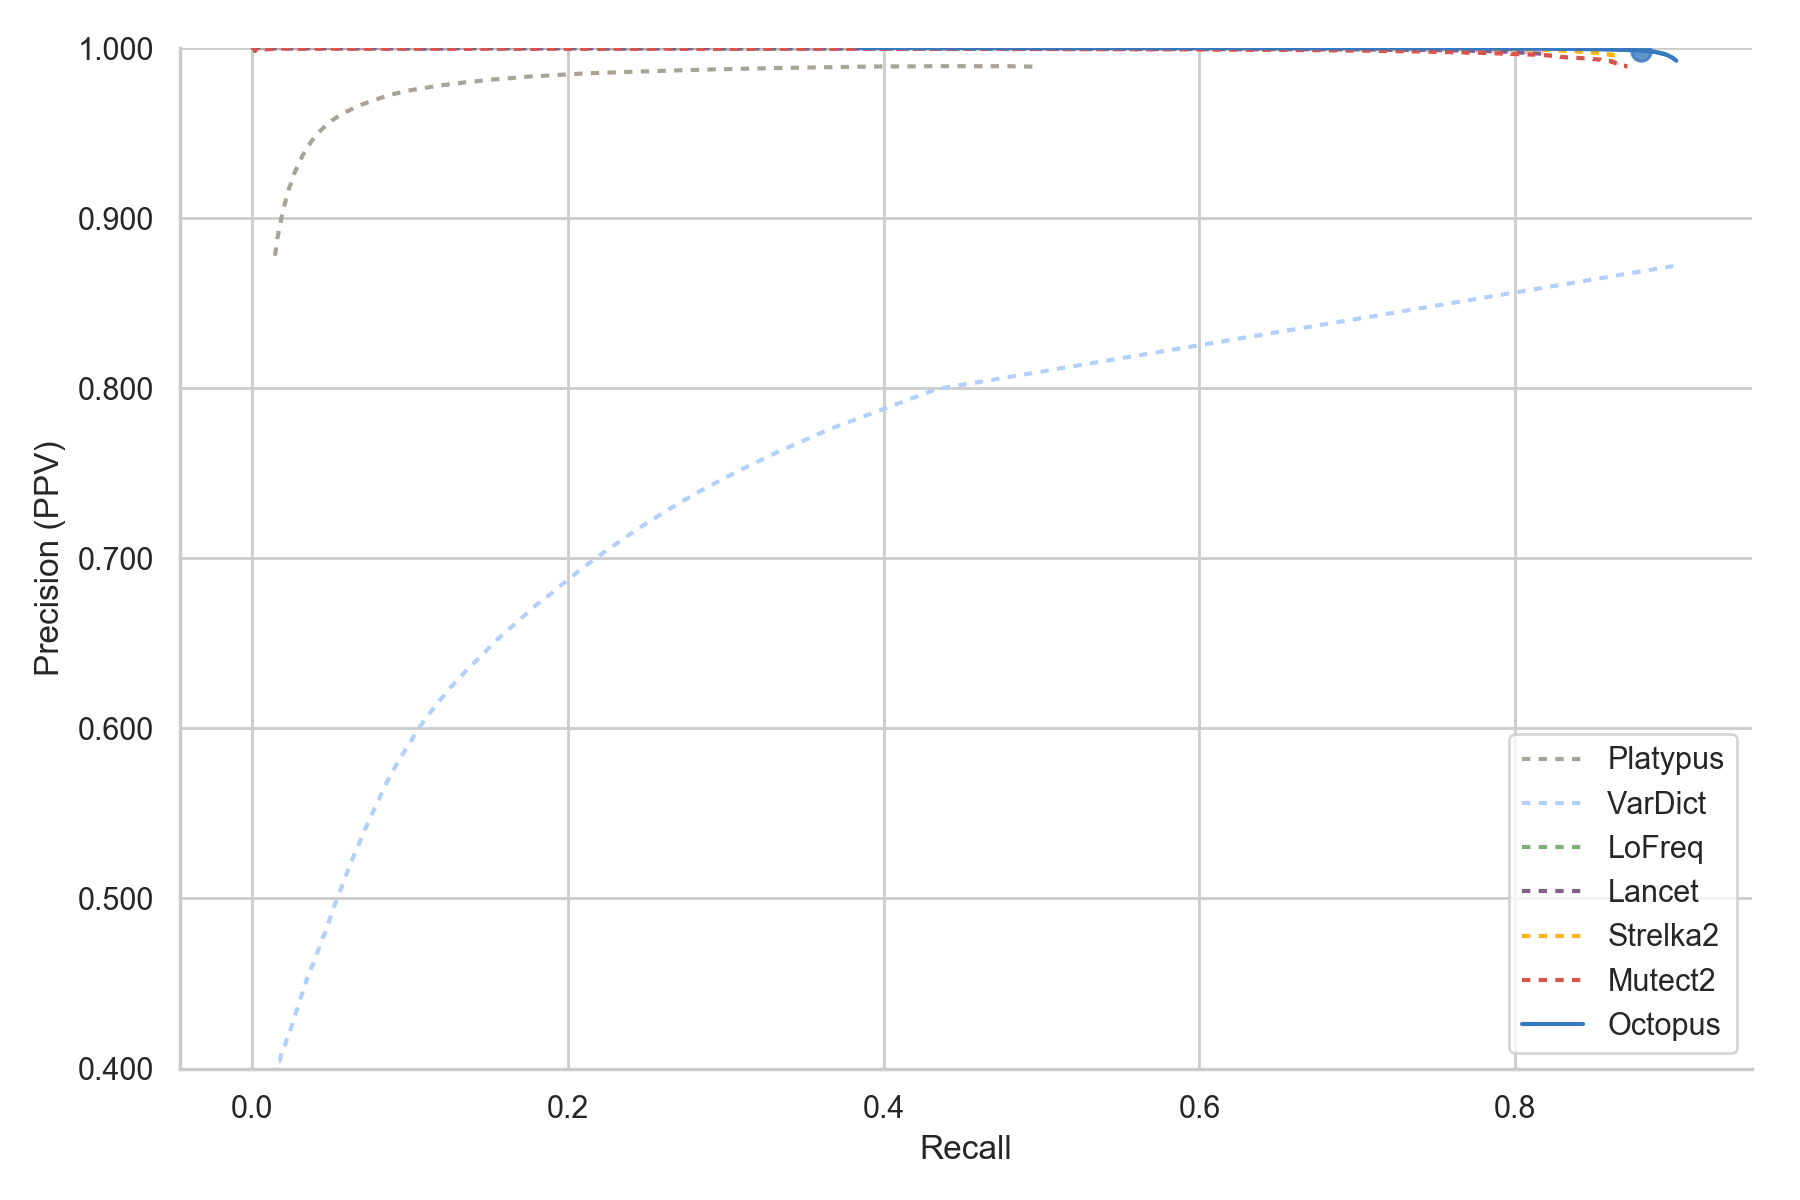

In [80]:
plot_precision_recall_helper('skin', 30, 60, marker_scores={'Octopus': 7.}, ylim=(.4, 1.))

<IPython.core.display.Javascript object>


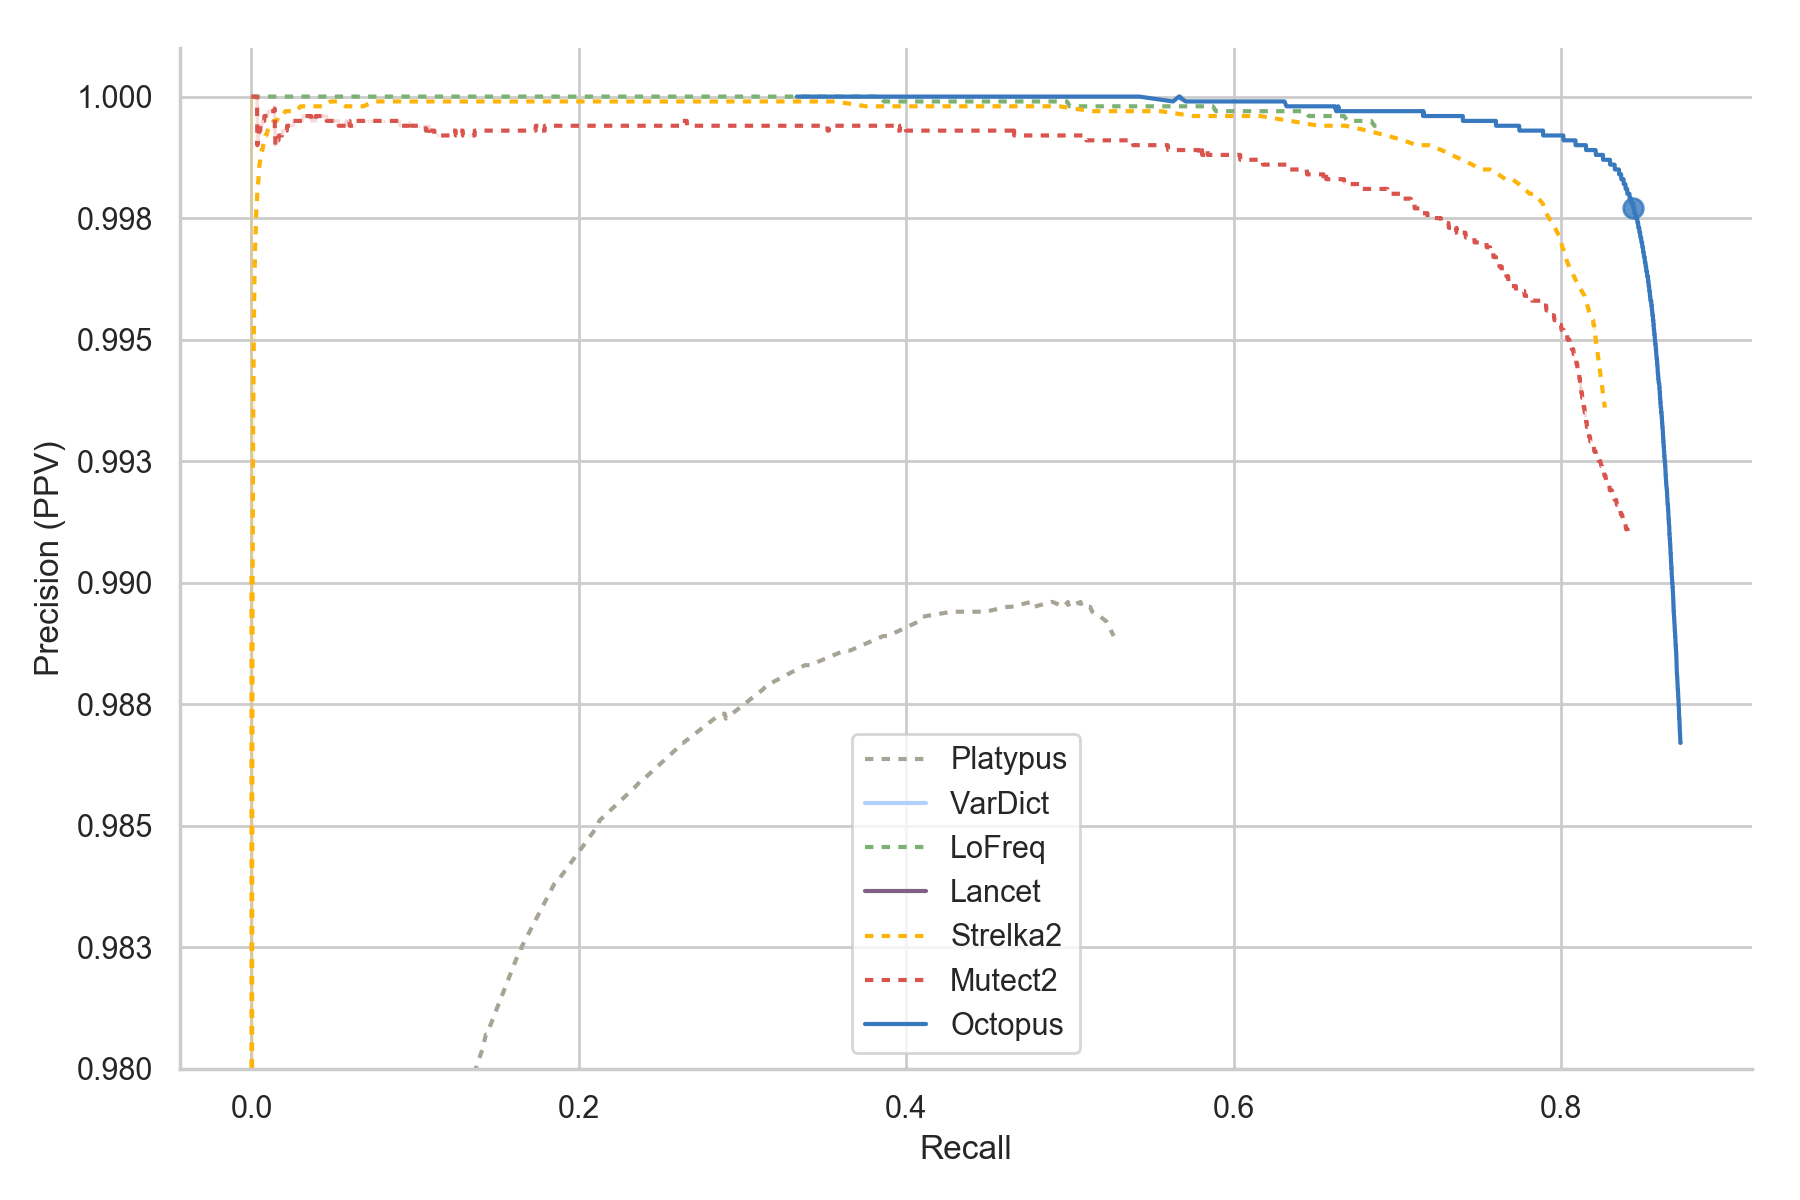

In [308]:
plot_precision_recall_helper('skin', 30, 45, marker_scores={'Octopus': 7.}, ylim=(0.98, 1.001))

<IPython.core.display.Javascript object>


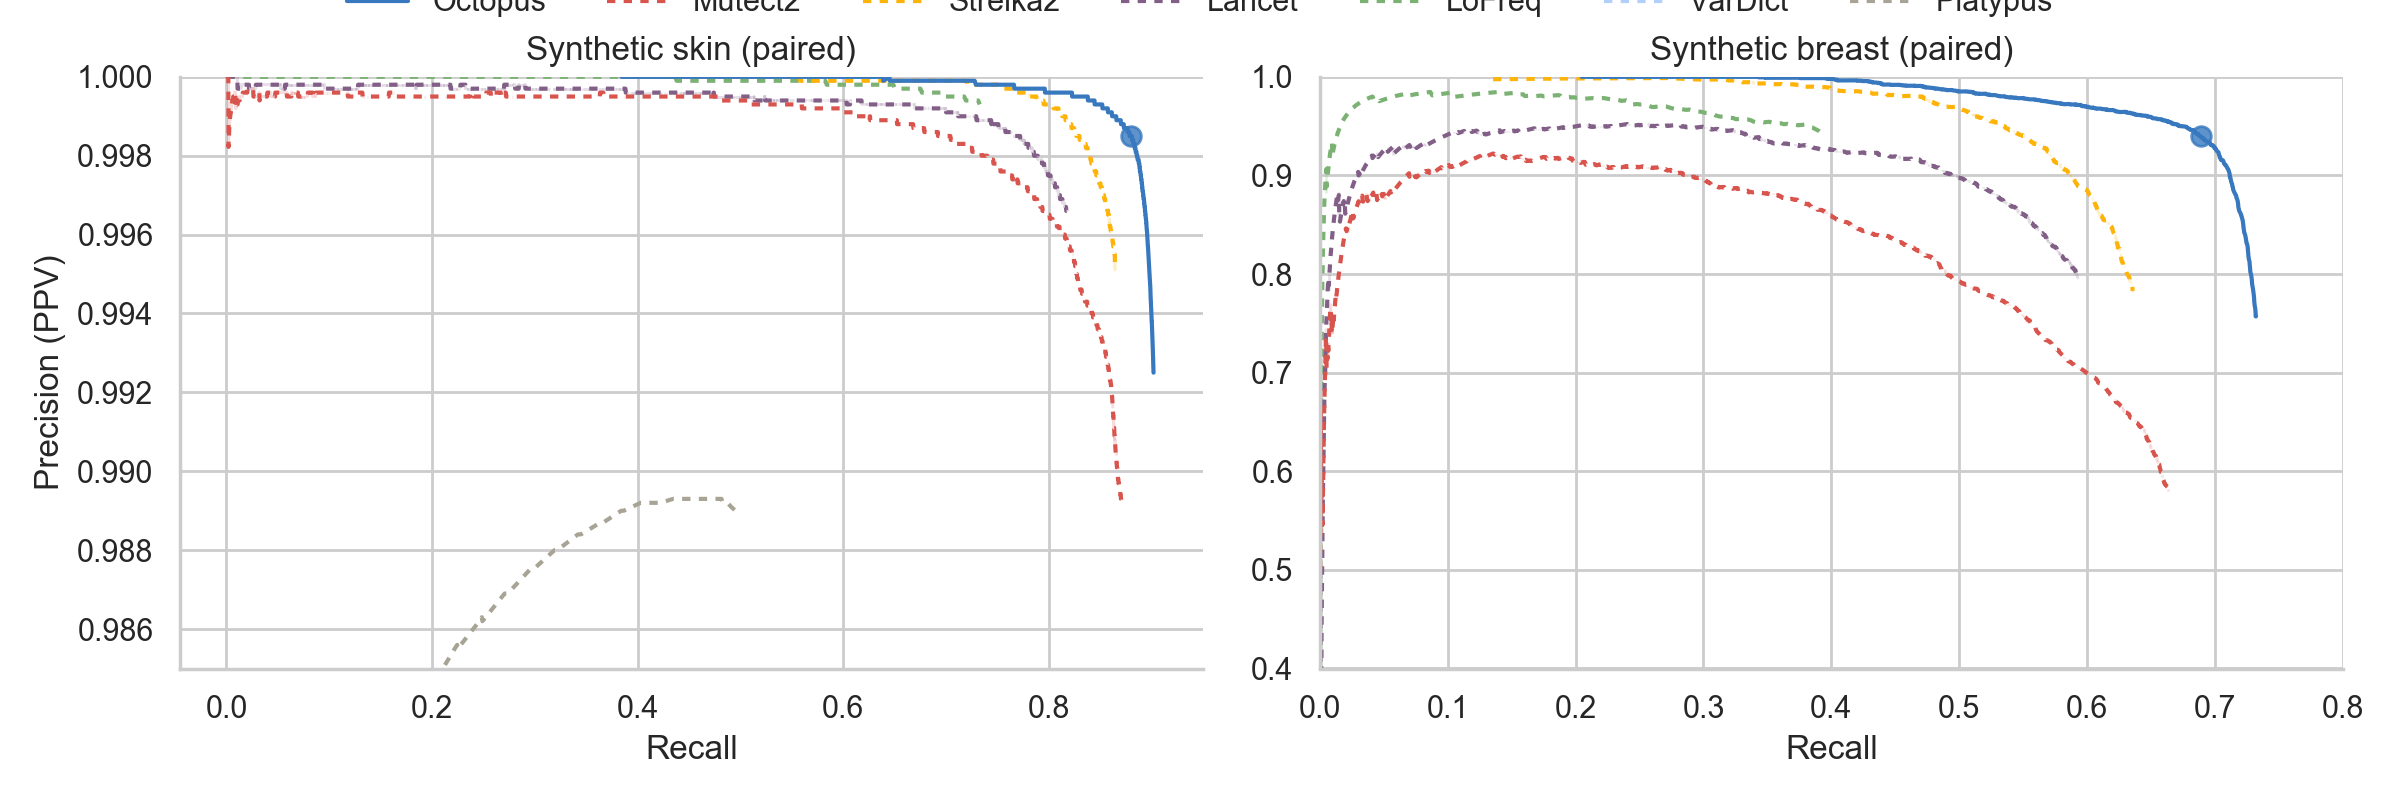

In [87]:
plot2_precision_recalls_helper('skin', 30, 60,
                              'breast', 35, 65,
                              title1='Synthetic skin (paired)',
                              title2='Synthetic breast (paired)',
                              marker_scores={'Octopus': 7.},
                              ylim1=(0.985, 1.), ylim2=(0.4, 1.), xlim2=(0., 0.8),
                              y_format2='%.1f',
                              legend=True,
                              save="/Users/dcooke/Documents/octopus-paper/figures/paired_somatic_precision_recall.pdf")

<IPython.core.display.Javascript object>


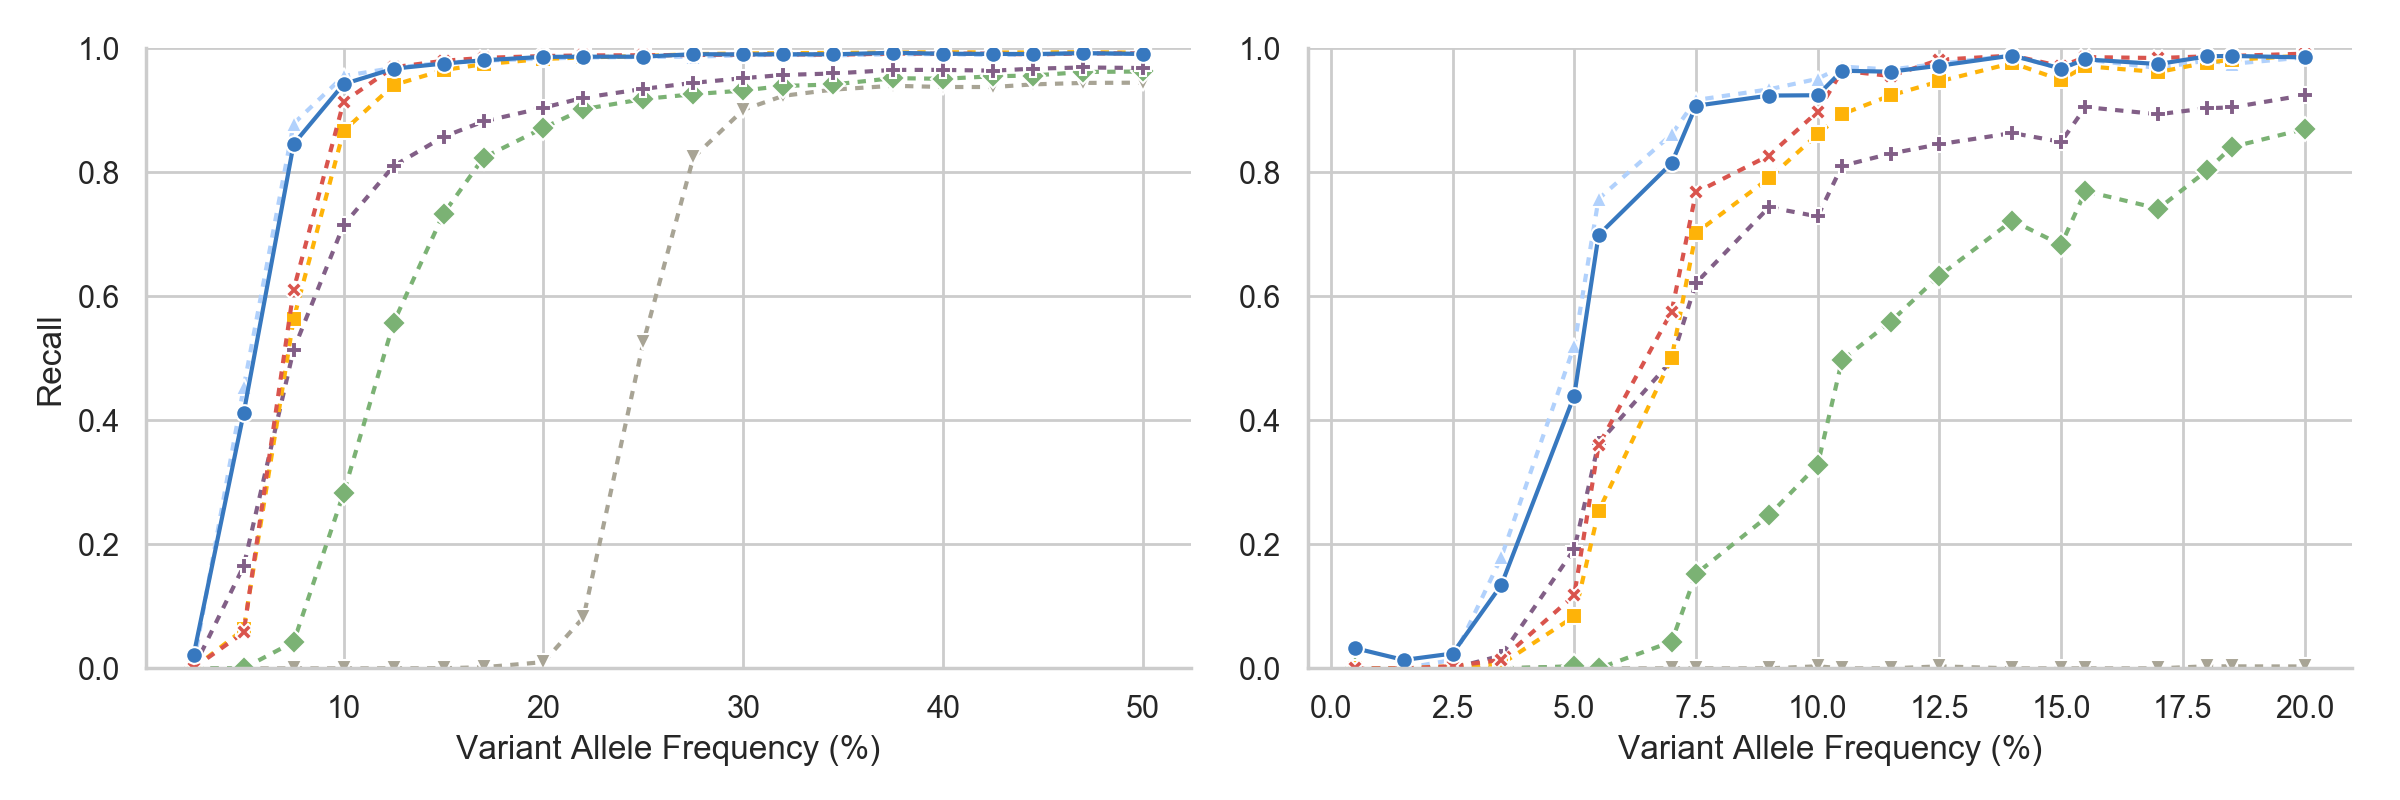

In [88]:
plot2_vaf_recalls_helper('skin', 30, 60,
                        'breast', 35, 65,
                        title1=None,
                        title2=None,
                        legend=False,
                        save="/Users/dcooke/Documents/octopus-paper/figures/paired_somatic_vaf_recall.pdf")

<IPython.core.display.Javascript object>


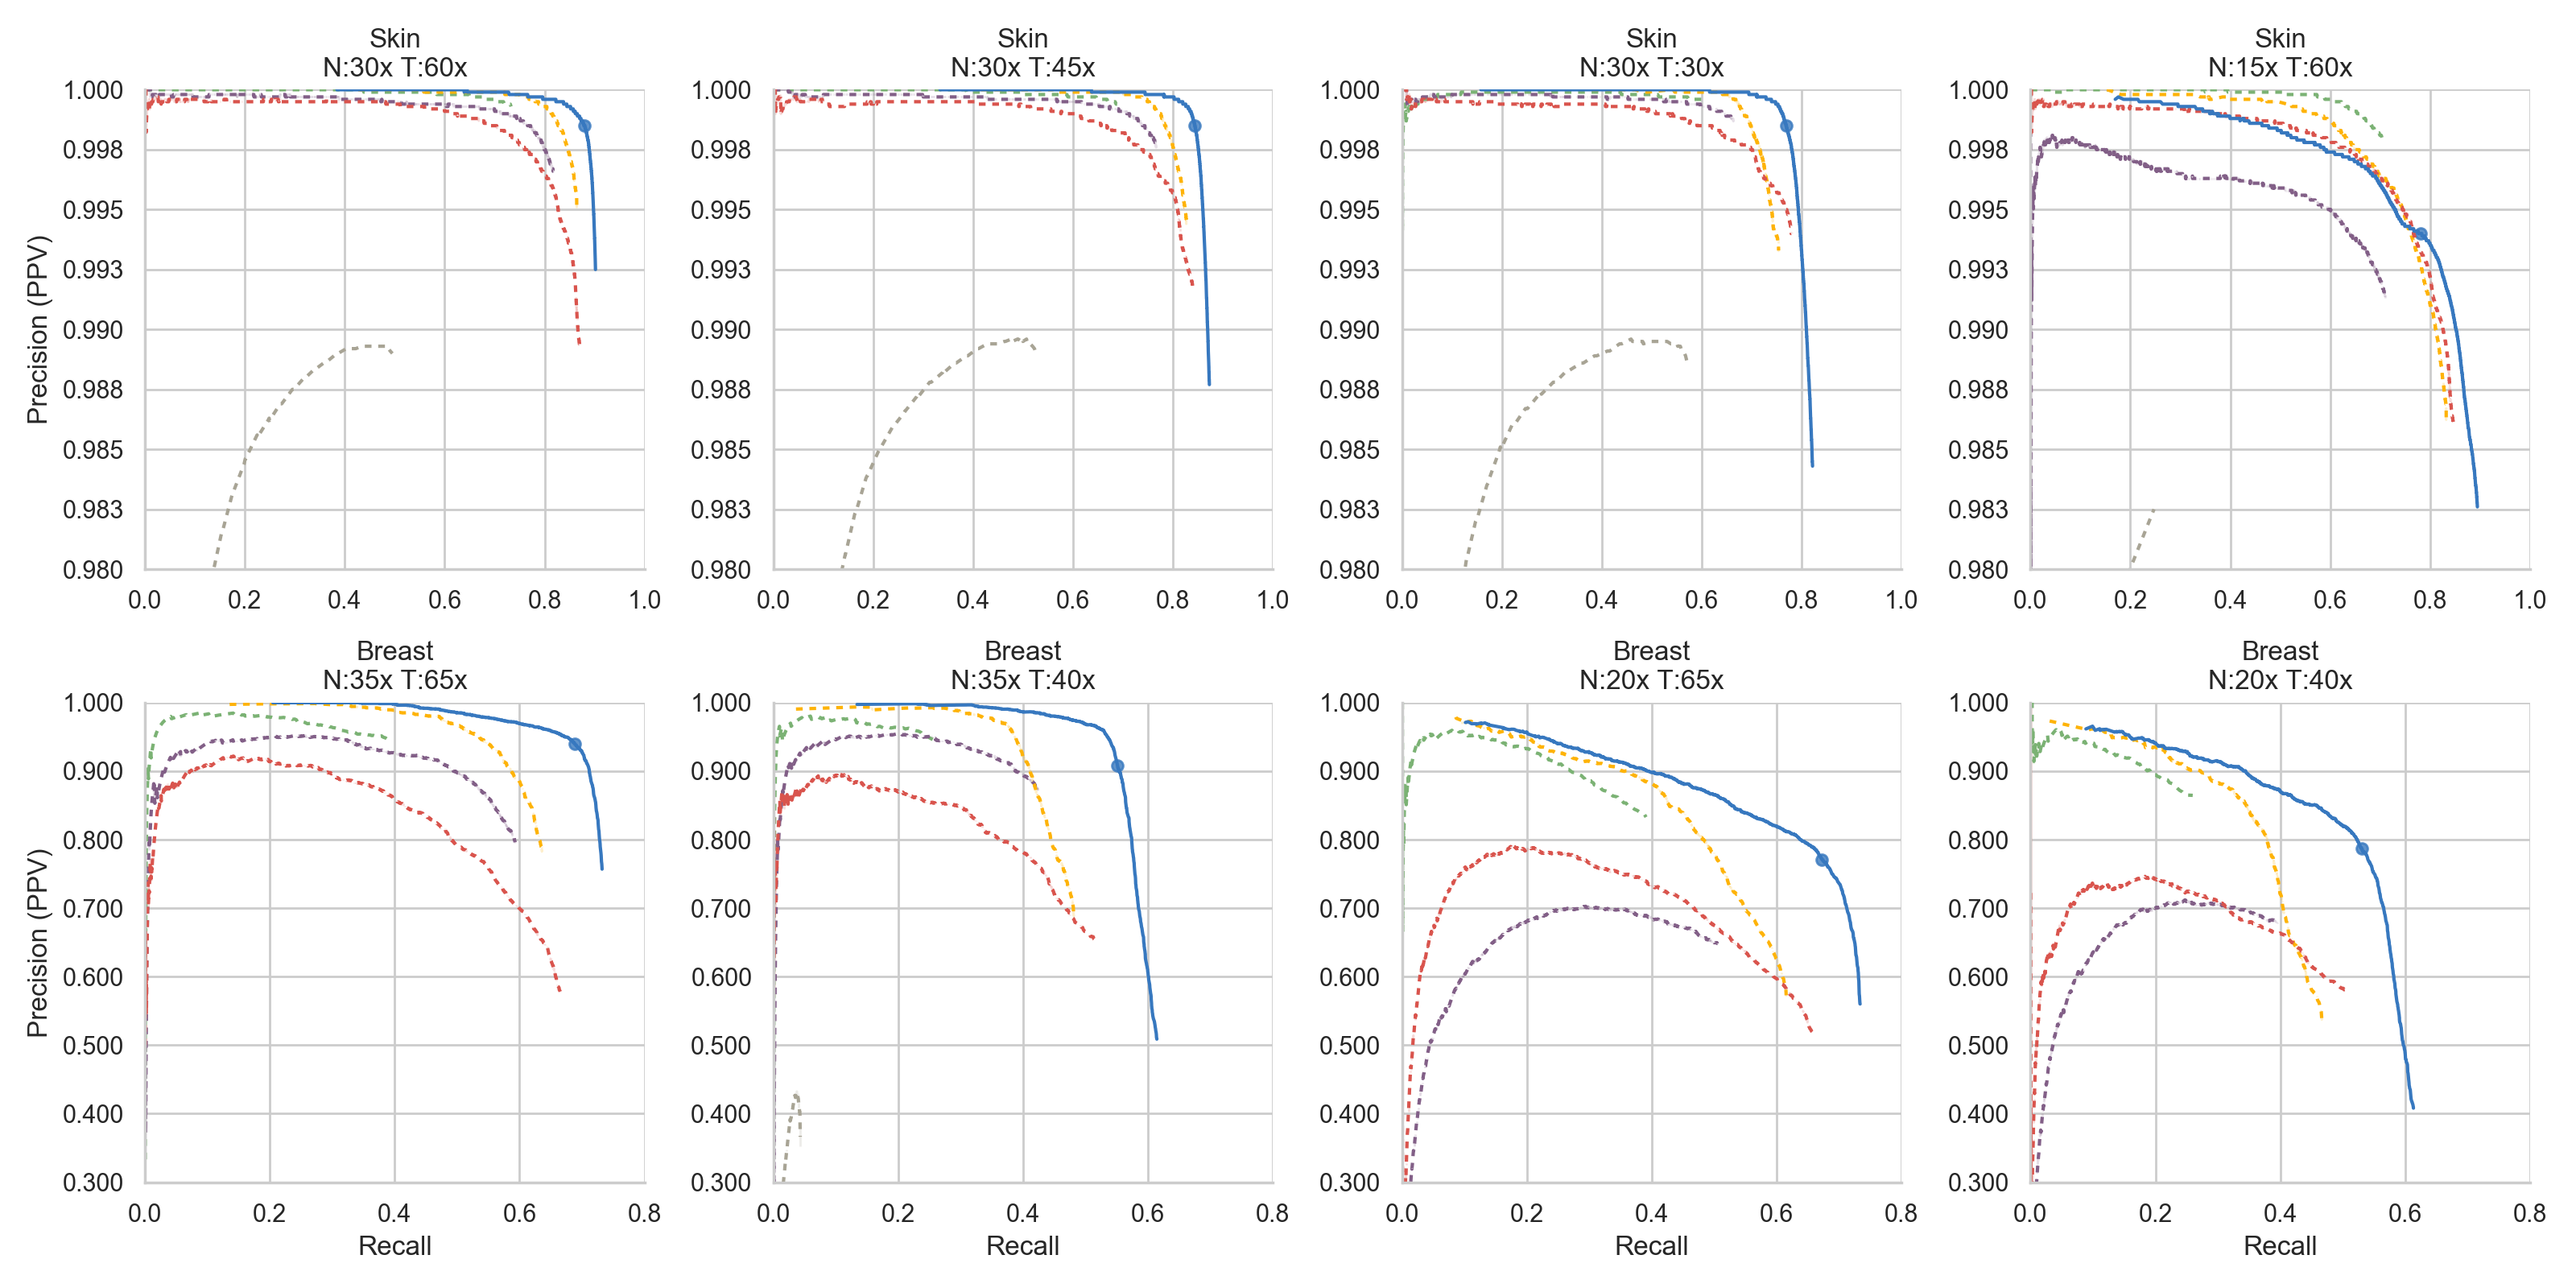

In [89]:
plot_final_precision_recalls_helper([('skin', 30, 60), ('skin', 30, 45), ('skin', 30, 30), ('skin', 15, 60),
                                     ('breast', 35, 65), ('breast', 35, 40), ('breast', 20, 65), ('breast', 20, 40)],
                                    limits=4 * [((0., 1.), (0.98, 1.))] + 4 * [((0., .8), (0.3, 1.))],
                                    show_tumour=True,
                                    save="/Users/dcooke/Documents/octopus-paper/supplementary/figures/paired_somatic_precision_recall.pdf")

<IPython.core.display.Javascript object>


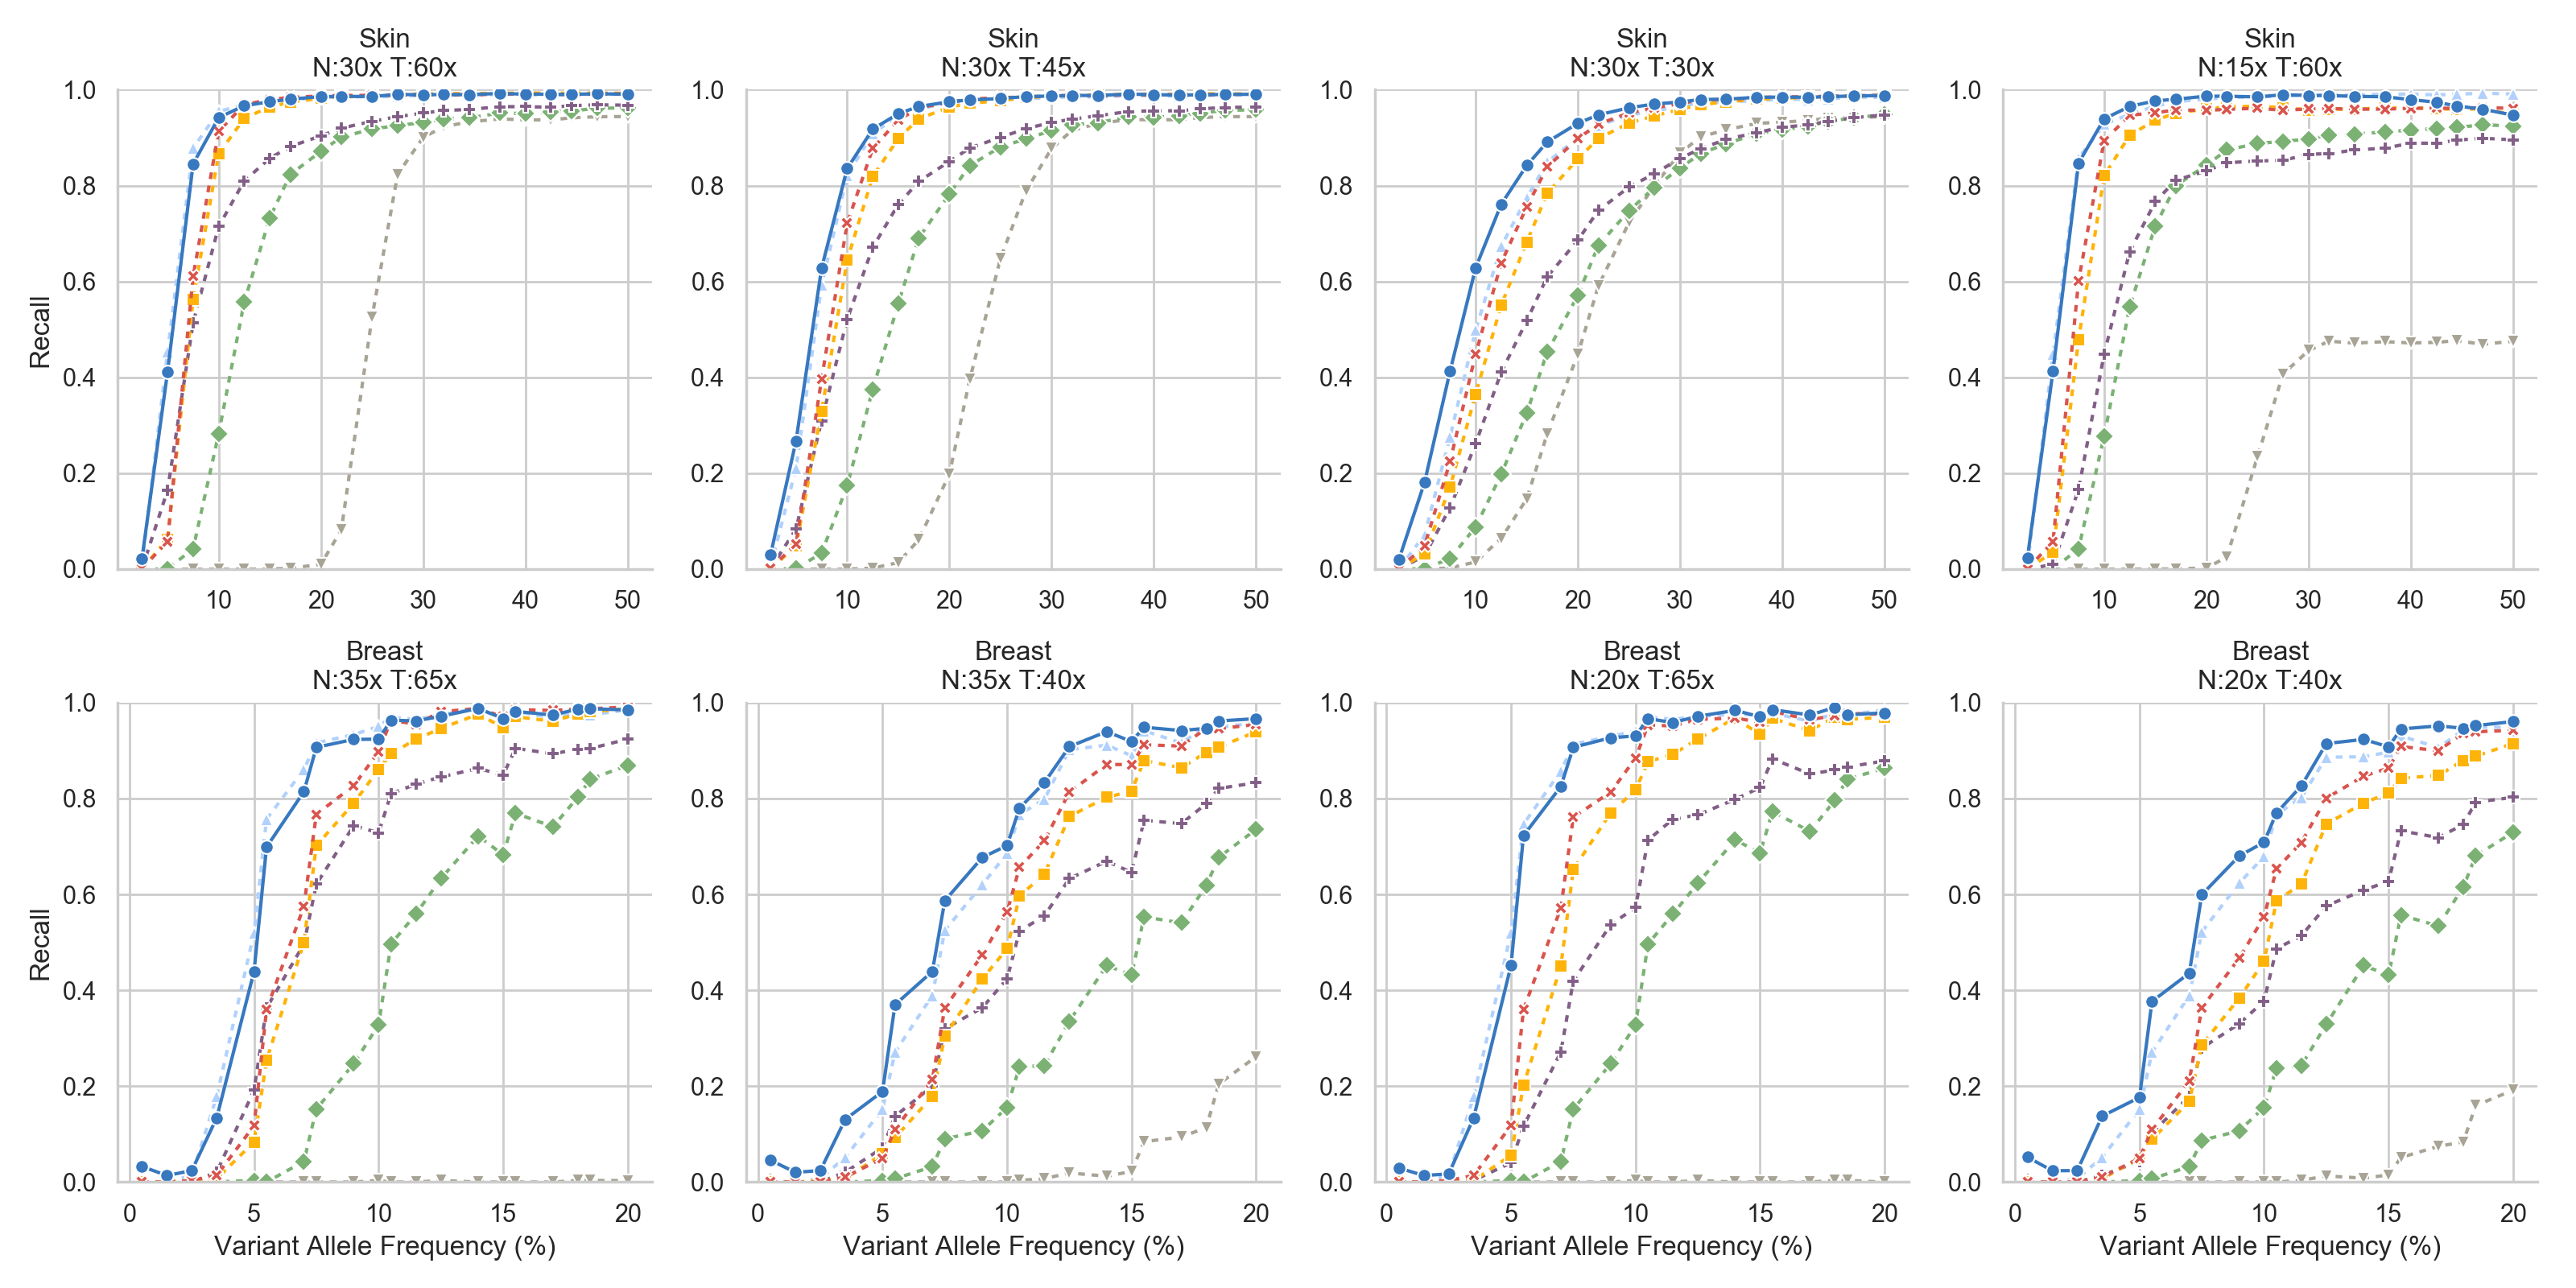

In [90]:
plot_final_vaf_recalls_helper([('skin', 30, 60), ('skin', 30, 45), ('skin', 30, 30), ('skin', 15, 60),
                               ('breast', 35, 65), ('breast', 35, 40), ('breast', 20, 65), ('breast', 20, 40)],
                              show_tumour=True,
                              save="/Users/dcooke/Documents/octopus-paper/supplementary/figures/paired_somatic_vaf_recall.pdf")

In [85]:
read_all_test_performance_summaries()

Test  Normal depth  Tumour depth    caller True-pos-baseline  \
0    skin            15            60   Octopus            251710   
1    skin            15            60   Mutect2            238088   
2    skin            15            60  Strelka2            234156   
3    skin            15            60    Lancet            200337   
4    skin            15            60    LoFreq            199181   
5    skin            15            60   VarDict            253293   
6    skin            15            60  Platypus             69530   
0    skin            30            30   Octopus            231214   
1    skin            30            30   Mutect2            219304   
2    skin            30            30  Strelka2            212106   
3    skin            30            30    Lancet            186781   
4    skin            30            30    LoFreq            170193   
5    skin            30            30   VarDict            221108   
6    skin            30            30  Platypus            161007   
0    skin            30            45   Octopus            245479   
1    skin            30            45   Mutect2            236521   
2    skin            30            45  Strelka2            232496   
3    skin            30            45    Lancet            215495   
4    skin            30            45    LoFreq            193533   
5    skin            30            45   VarDict            242924   
6    skin            30            45  Platypus            148213   
0    skin            30            60   Octopus            253689   
1    skin            30            60   Mutect2            244985   
2    skin            30            60  Strelka2            243142   
3    skin            30            60    Lancet            229919   
4    skin            30            60    LoFreq            206142   
5    skin            30            60   VarDict            254466   
6    skin            30            60  Platypus            139286   
0  breast            20            40   Octopus              3652   
1  breast            20            40   Mutect2              3041   
2  breast            20            40  Strelka2              2778   
3  breast            20            40    Lancet              2355   
4  breast            20            40    LoFreq              1547   
5  breast            20            40   VarDict              3443   
6  breast            20            40  Platypus               186   
0  breast            20            65   Octopus              4369   
1  breast            20            65   Mutect2              3913   
2  breast            20            65  Strelka2              3664   
3  breast            20            65    Lancet              3009   
4  breast            20            65    LoFreq              2327   
5  breast            20            65   VarDict              4406   
6  breast            20            65  Platypus                 4   
0  breast            35            40   Octopus              3656   
1  breast            35            40   Mutect2              3074   
2  breast            35            40  Strelka2              2864   
3  breast            35            40    Lancet              2527   
4  breast            35            40    LoFreq              1554   
5  breast            35            40   VarDict              3464   
6  breast            35            40  Platypus               254   
0  breast            35            65   Octopus              4359   
1  breast            35            65   Mutect2              3960   
2  breast            35            65  Strelka2              3785   
3  breast            35            65    Lancet              3529   
4  breast            35            65    LoFreq              2337   
5  breast            35            65   VarDict              4421   
6  breast            35            65  Platypus                 6   

  True-pos-call False-pos False-neg Precision Sensitivity F-measure  
0

In [91]:
summary_df = read_all_test_performance_summaries('pass')
with open('/Users/dcooke/Documents/octopus-paper/supplementary/paired_somatic_summary.tex', 'w') as f:
    f.write(summary_df.to_latex(index=False))

Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/Octopus
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/Mutect2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/Strelka2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/Lancet
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/LoFreq
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/VarDict
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N30/T30/test/pass/Platypus


<IPython.core.display.Javascript object>


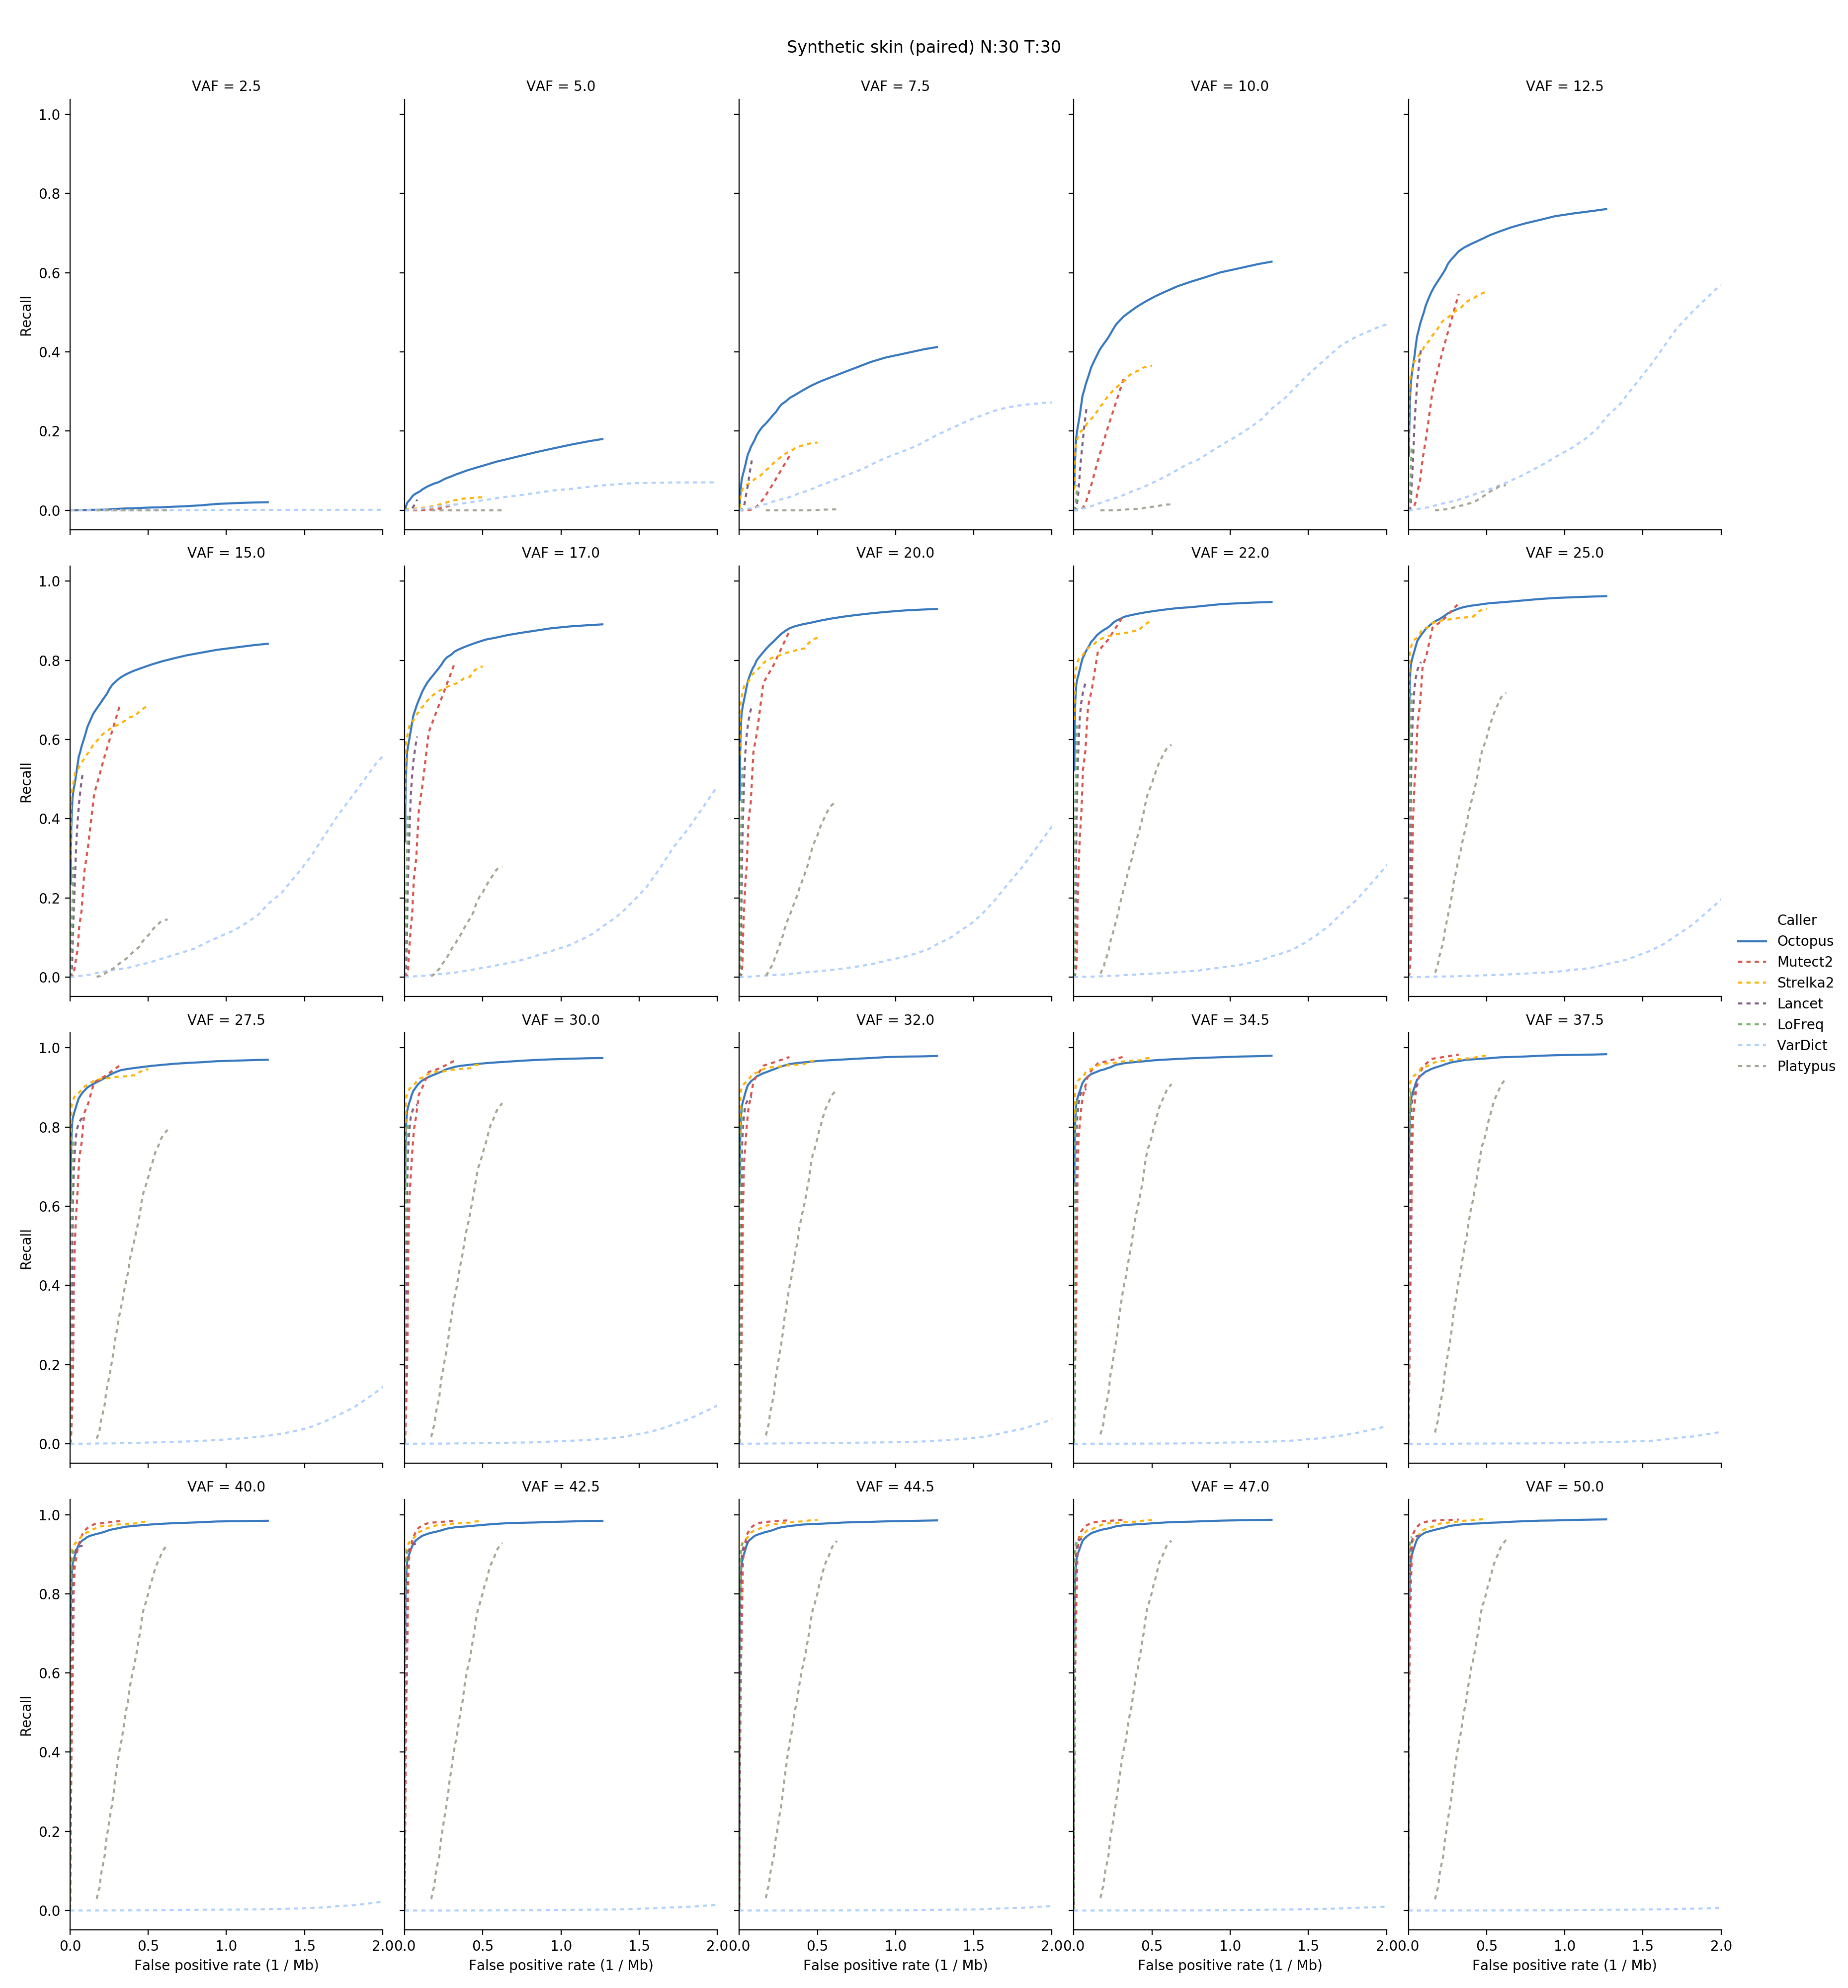

Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/Octopus
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/Mutect2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/Strelka2
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/Lancet
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/LoFreq
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/VarDict
Found existing evaluation: /Users/dcooke/Genomics/octopus/paper/somatic/paired/eval/skin/N15/T60/test/pass/Platypus


<IPython.core.display.Javascript object>


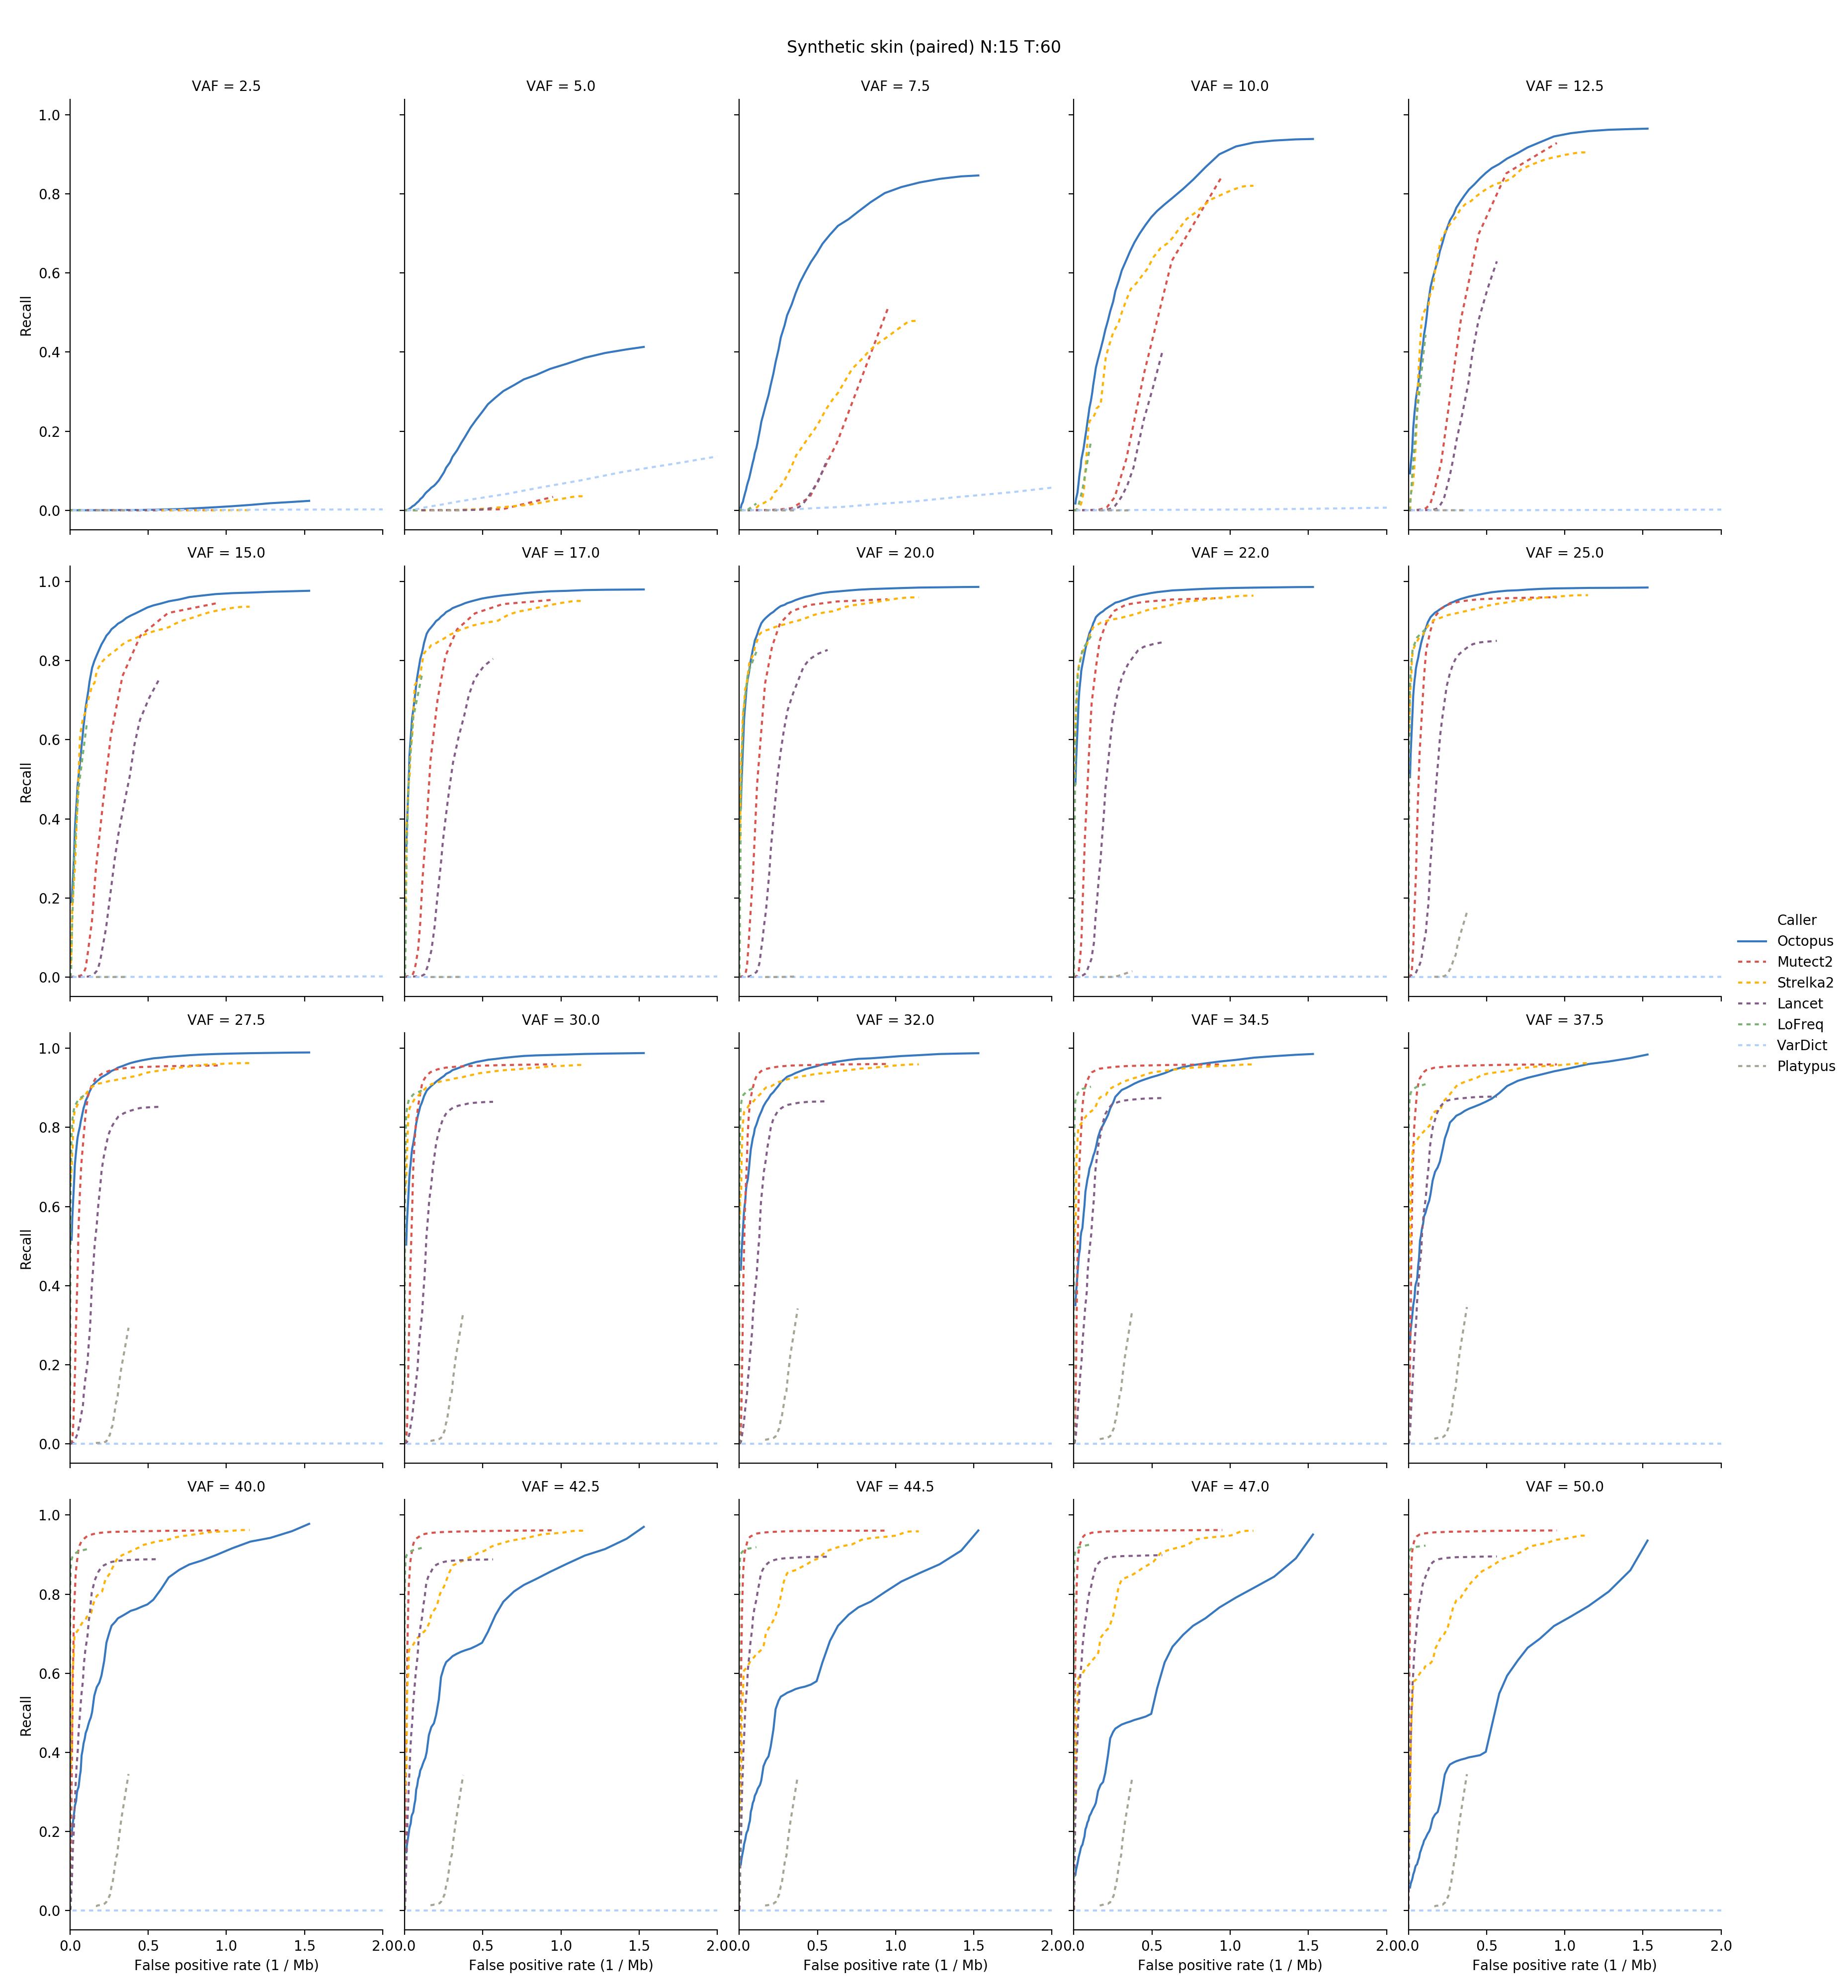

In [35]:
plot_vaf_score_recalls_helper('skin', 30, 30, xlim=(0., 2.), save='/Users/dcooke/Documents/octopus-paper/supplementary/figures/paired_somatic_skin_n30_t30_vaf_recall.pdf')
plot_vaf_score_recalls_helper('skin', 15, 60, xlim=(0., 2.), save='/Users/dcooke/Documents/octopus-paper/supplementary/figures/paired_somatic_skin_n15_t60_vaf_recall.pdf')

<IPython.core.display.Javascript object>


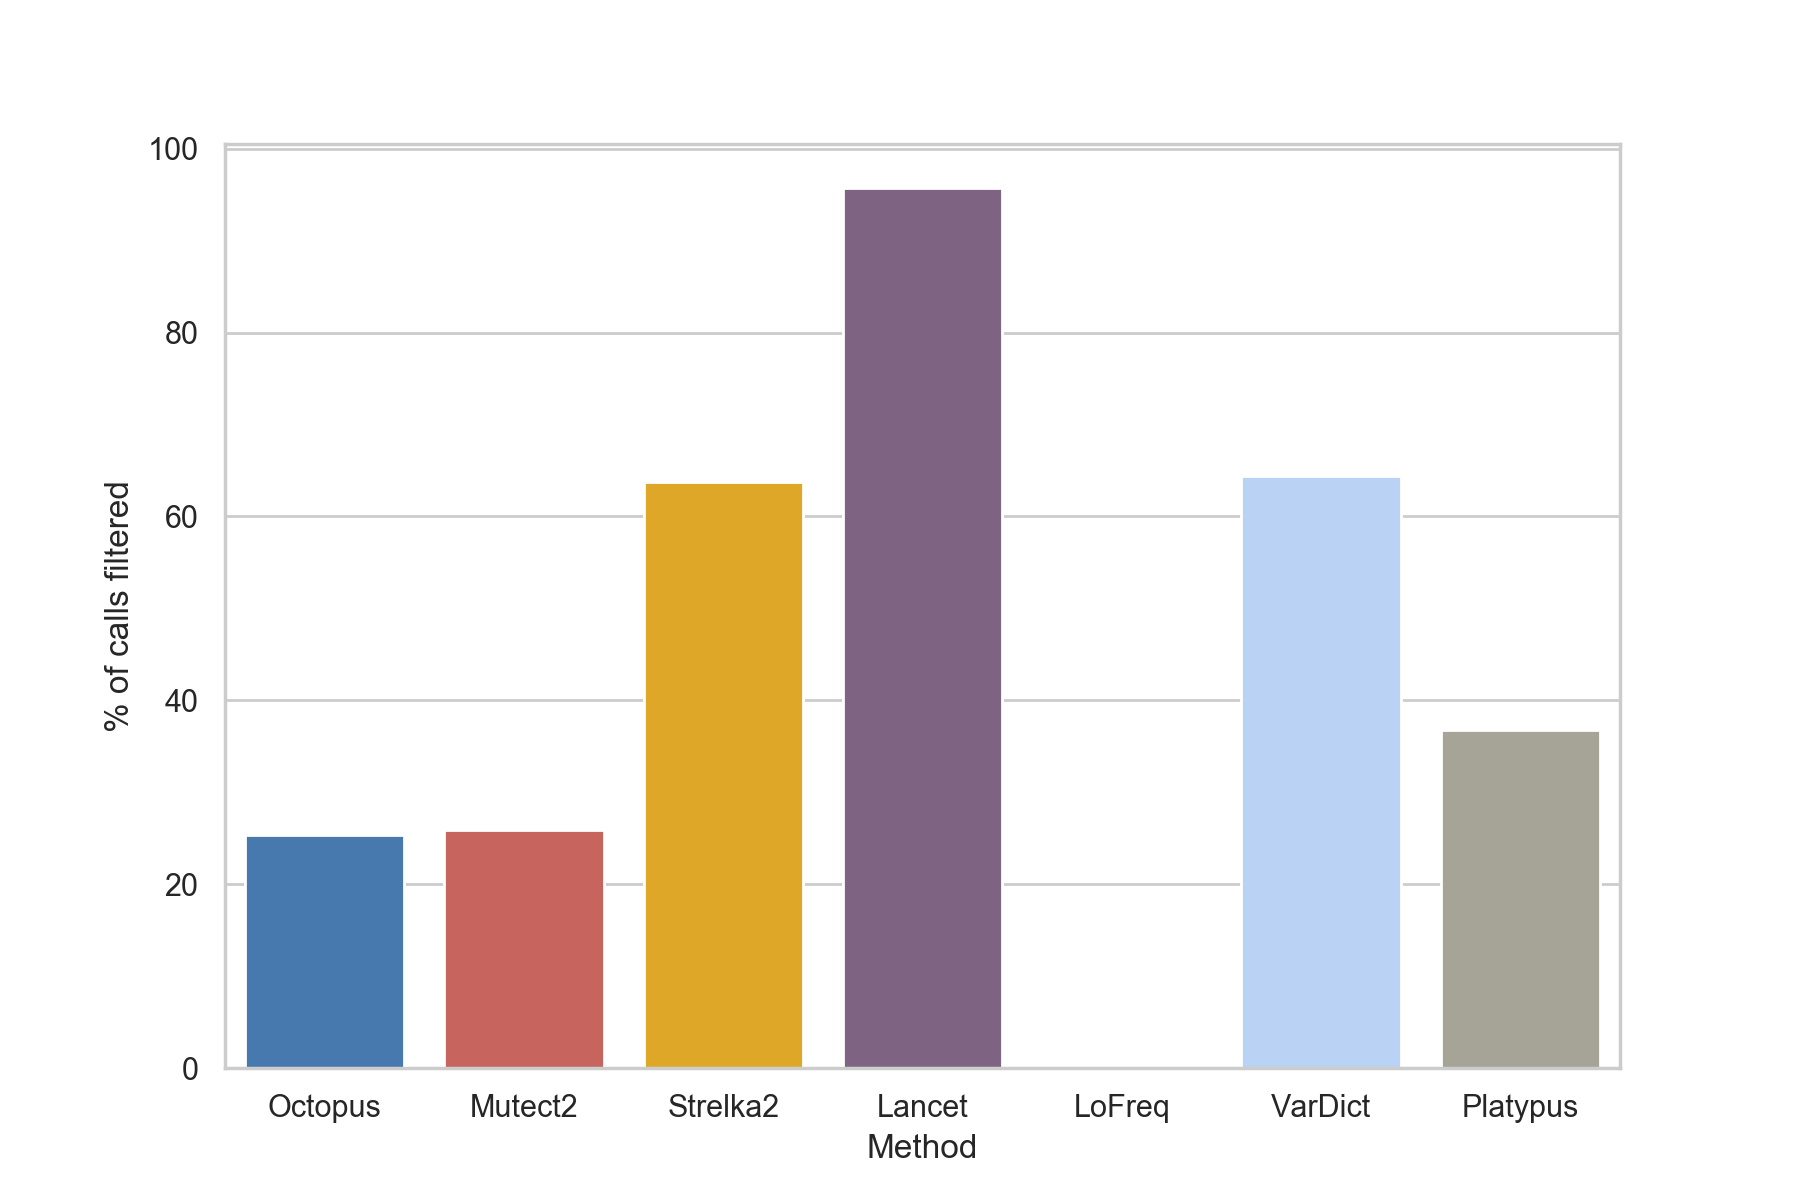

In [149]:
filtered_skin_summary_df = read_performance_summaries_helper('skin', 'test')
unfiltered_skin_summary_df = read_performance_summaries_helper('skin', 'test', 'unfiltered')
filtered_skin_summary_df['filtered calls'] = filtered_skin_summary_df.apply(lambda row: int(row['True-pos-call']) + int(row['False-pos']), axis=1)
df1 = filtered_skin_summary_df[['caller', 'filtered calls']]
unfiltered_skin_summary_df['unfiltered calls'] = unfiltered_skin_summary_df.apply(lambda row: int(row['True-pos-call']) + int(row['False-pos']), axis=1)
df2 = unfiltered_skin_summary_df[['caller', 'unfiltered calls']]
skin_filtering_df = pd.merge(df1.assign(x=df1.caller.astype(str)),
                             df2.assign(x=df1.caller.astype(str)),
                             how='left', on='caller')
skin_filtering_df = skin_filtering_df[['caller', 'filtered calls', 'unfiltered calls']]
skin_filtering_df['filtered fraction'] = skin_filtering_df.apply(lambda row: 100 * (1 - float(row['filtered calls']) / int(row['unfiltered calls'])), axis=1)

filtered_breast_summary_df = read_performance_summaries_helper('breast', 'test')
unfiltered_breast_summary_df = read_performance_summaries_helper('breast', 'test', 'unfiltered')
filtered_breast_summary_df['filtered calls'] = filtered_breast_summary_df.apply(lambda row: int(row['True-pos-call']) + int(row['False-pos']), axis=1)
df1 = filtered_breast_summary_df[['caller', 'filtered calls']]
unfiltered_breast_summary_df['unfiltered calls'] = unfiltered_breast_summary_df.apply(lambda row: int(row['True-pos-call']) + int(row['False-pos']), axis=1)
df2 = unfiltered_breast_summary_df[['caller', 'unfiltered calls']]
breast_filtering_df = pd.merge(df1.assign(x=df1.caller.astype(str)),
                             df2.assign(x=df1.caller.astype(str)),
                             how='left', on='caller')
breast_filtering_df = breast_filtering_df[['caller', 'filtered calls', 'unfiltered calls']]
breast_filtering_df['filtered fraction'] = breast_filtering_df.apply(lambda row: 100 * (1 - float(row['filtered calls']) / int(row['unfiltered calls'])), axis=1)

skin_filtering_df['tumour'] = 'skin'
breast_filtering_df['tumour'] = 'breast'
filtering_summary_df = pd.concat([skin_filtering_df, breast_filtering_df])

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.barplot(x="caller", y="filtered fraction",
                palette=caller_colours,
                data=skin_filtering_df,
                ax=ax)
ax.set(ylabel='% of calls filtered', xlabel='Method')
plt.savefig("/Users/dcooke/Documents/octopus-paper/supplementary/figures/filtering.pdf",
            format='pdf', 
            transparent=True,
            bbox_inches='tight')

In [146]:
import pysam as ps

def count_records(vcf_path, matches):
    vcf = ps.VariantFile(vcf_path)
    return sum(matches(record) for record in vcf)

def is_indel(ref, alt, min_size=None, max_size=None):
    if min_size is None and max_size is None:
        return len(alt) != len(ref)
    else:
        size = abs(len(alt) - len(record.ref))
        if min_size is None:
            return size <= max_size
        elif max_size is None:
            return size >= min_size
        else:
            return min_size <= size <= max_size

def has_indel(record, min_size=None):
    return any(is_indel(record.ref, alt, min_size=min_size) for alt in record.alts)

def count_indel_records(vcf_path, min_size=None):
    return count_records(vcf_path, lambda record: has_indel(record, min_size))

def count_alt_indels(record, min_size=None):
    return sum(is_indel(record.ref, alt) for alt in record.alts)

def count_called_indels(vcf_path, min_size=None):
    vcf = ps.VariantFile(vcf_path)
    return sum(count_alt_indels(record, min_size=min_size) for record in vcf)

def subset_vcf(in_vcf_path, bed_regions, out_vcf_path):
    cmd = ['bcftools', 'view', '-T', bed_regions, '-Oz', '-o', out_vcf_path, in_vcf_path]
    call(cmd)

def read_indel_size_distribution(vcf_path, bed_regions=None):
    if bed_regions is not None:
        tmp_vcf = vcf_path.replace('.vcf', '.tmp.vcf')
        subset_vcf(vcf_path, bed_regions, tmp_vcf)
        res = read_indel_size_distribution(tmp_vcf)
        remove_vcf(tmp_vcf)
        return res
    vcf = ps.VariantFile(vcf_path)
    dist = {}
    min_size, max_size = None, None
    for record in vcf:
        for alt in record.alts:
            if is_indel(record.ref, alt):
                size = len(alt) - len(record.ref)
                if size in dist:
                    dist[size] += 1
                else:
                    dist[size] = 1
                if min_size is None:
                    min_size = size
                    max_size = min_size
                else:
                    min_size = min(min_size, size)
                    max_size = max(max_size, size)
    if max_size is not None:
        sizes = list(range(min_size, max_size + 1))
    else:
        sizes = []
    counts = [dist[size] if size in dist else 0 for size in sizes]
    return sizes, counts, dist

def read_indel_size_distribution_df(caller, vcf_path, bed_regions=None):
    sizes, counts, _ = read_indel_size_distribution(vcf_path, bed_regions=bed_regions)
    result = pd.DataFrame({'caller': caller, 'size': sizes, 'count': counts})
    result[['size', 'count']] = result[['size', 'count']].astype(int)
    return result

def read_caller_indel_stats(caller, rtg_eval_dir, bed_regions=None):
    tps = join(rtg_eval_dir, 'tp.vcf.gz')
    return read_indel_size_distribution_df(caller, tps, bed_regions=bed_regions)

def read_truth_indel_stats_df(rtg_eval_dir, bed_regions=None):
    tps = join(rtg_eval_dir, 'tp-baseline.vcf.gz')
    tp_sizes, _, tp_dist = read_indel_size_distribution(tps, bed_regions=bed_regions)
    fns = join(rtg_eval_dir, 'fn.vcf.gz')
    fn_sizes, _, fn_dist = read_indel_size_distribution(fns, bed_regions=bed_regions)
    min_size, max_size = min(tp_sizes[0], fn_sizes[0]), max(tp_sizes[-1], fn_sizes[-1])
    if max_size is not None:
        sizes = list(range(min_size, max_size + 1))
    else:
        sizes = []
    dist = {}
    for size in sizes:
        dist[size] = 0
        if size in tp_dist:
            dist[size] += tp_dist[size]
        if size in fn_dist:
            dist[size] += fn_dist[size]
    counts = [dist[size] if size in dist else 0 for size in sizes]
    result = pd.DataFrame({'caller': 'Truth', 'size': sizes, 'count': counts})
    result[['size', 'count']] = result[['size', 'count']].astype(int)
    return result 

def read_indel_stats(sample, rtg_eval_dirs, add_truth=True, bed_regions=None):
    caller_dfs = []
    for caller, rtg_eval_dir in rtg_eval_dirs.items():
        if exists(rtg_eval_dir):
            caller_dfs.append(read_caller_indel_stats(caller, rtg_eval_dir, bed_regions=bed_regions))
            if add_truth:
                caller_dfs.append(read_truth_indel_stats_df(rtg_eval_dir, bed_regions=bed_regions))
                add_truth = False
    res = pd.concat(caller_dfs).fillna(0.)
    res['Sample'] = sample
    return res

In [54]:
def get_truth_count(df, sample, size):
    query_str = 'caller == "Truth"'
    query_str += ' and Sample=="' + sample + '"'
    query_str += ' and size==' + str(size)
    try:
        return int(df.query(query_str)['count'])
    except TypeError:
        return 0

def calculate_truth_fold_change(count, truth_count):
    if truth_count > 0:
        return 100 * float(count) / truth_count
    else:
        return np.nan if count == 0 else 100.

def calculate_truth_log_fold_change(count, truth_count):
    if truth_count > 0:
        return log(count) - log(truth_count)
    else:
        return 0.

In [201]:
skin_indel_stats_df = read_indel_stats('skin', rtg_eval_dirs['skin'][30,60]['test']['pass'])
breast_indel_stats_df = read_indel_stats('breast', rtg_eval_dirs['breast'][35,65]['test']['pass'])
indel_stats_df = pd.concat([skin_indel_stats_df, breast_indel_stats_df])

In [202]:
indel_stats_df['Truth % change'] = indel_stats_df.apply(lambda row: calculate_truth_fold_change(row['count'], get_truth_count(indel_stats_df, row['Sample'], row['size'])), axis=1)

<IPython.core.display.Javascript object>


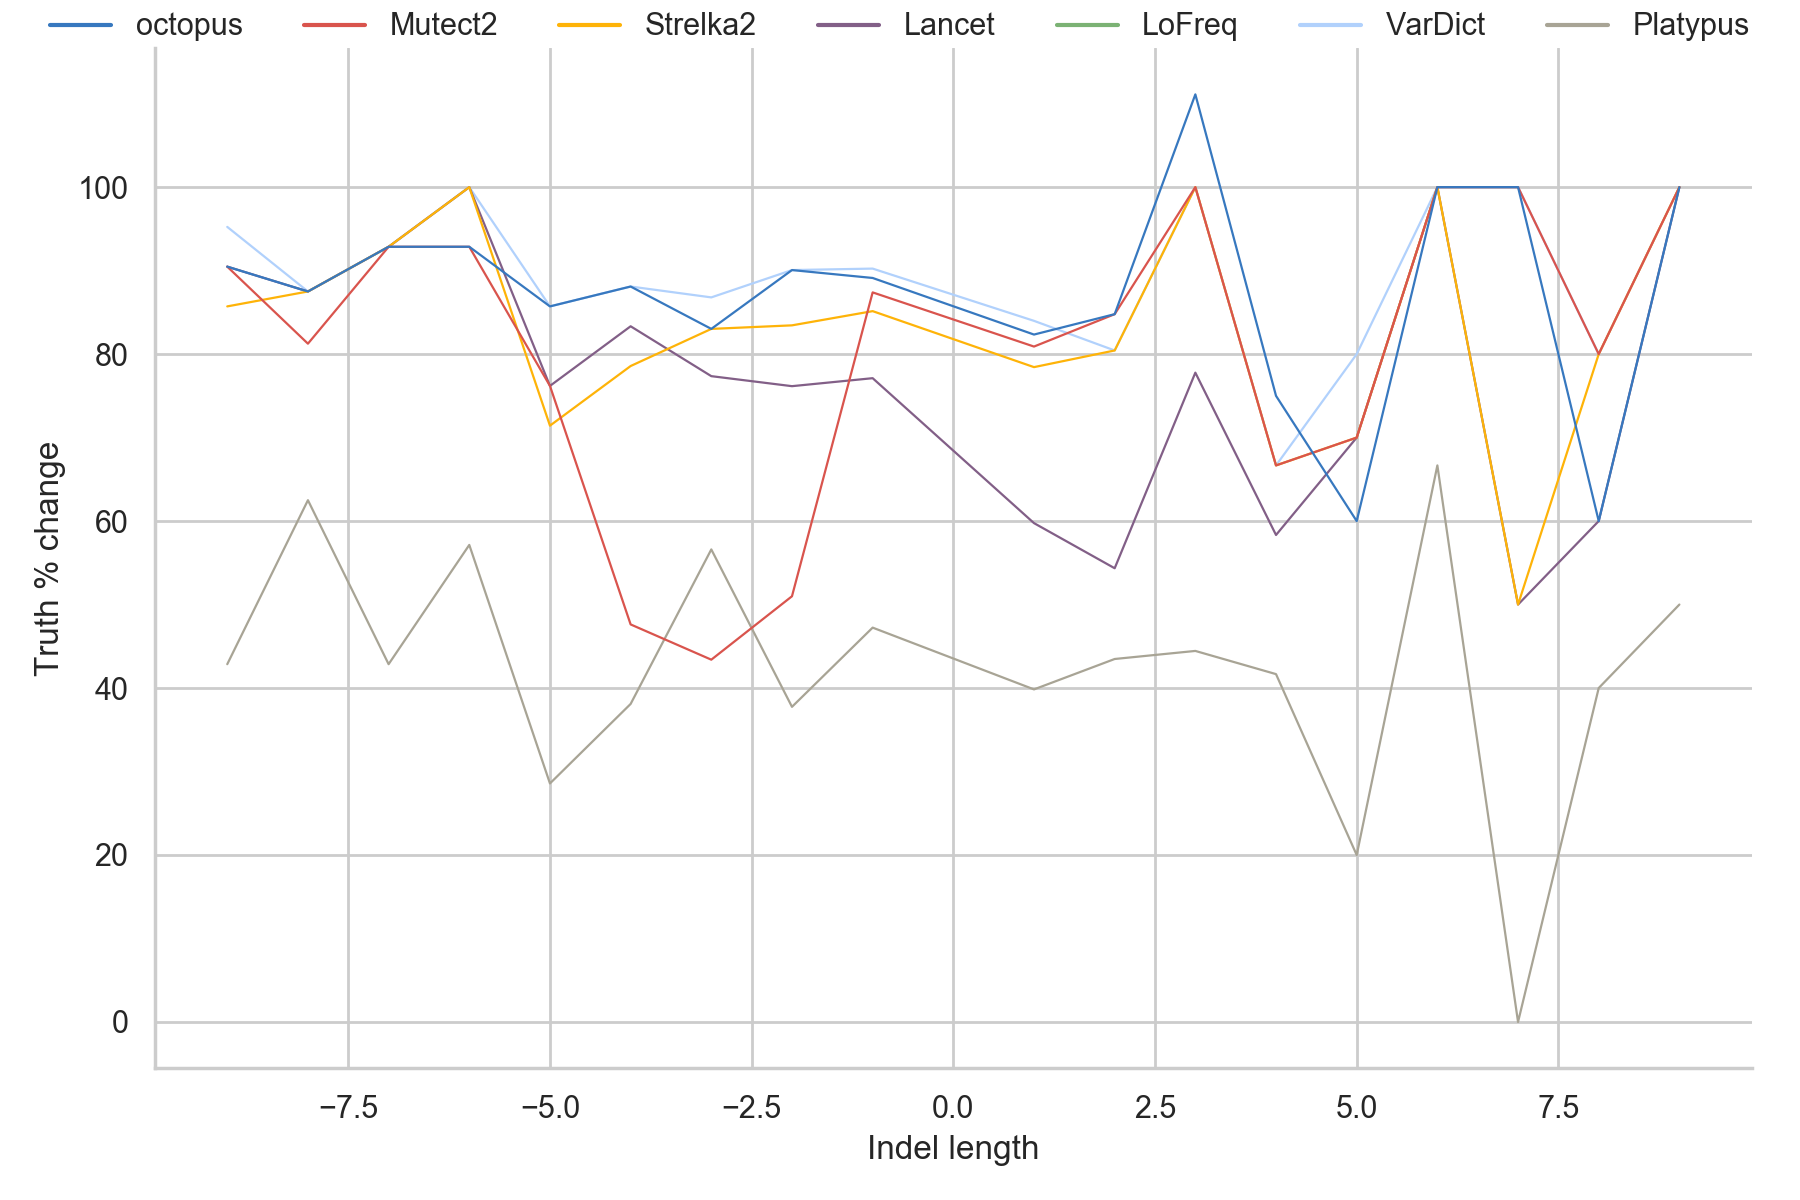

In [145]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.lineplot(x="size", y="Truth % change", hue="caller",
                    palette=caller_colours,
                    hue_order=list(reversed(callers)),
#                     s=20, marker=".",
                     linewidth=0.8,
                    data=indel_stats_df.query('caller != "Truth" and Sample=="skin" and -10 < size < 10 and abs(size) > 0'),
                    ax=ax)
sns.despine(ax=ax)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles=reversed(handles[1:]), labels=reversed(labels[1:]),
                 frameon=False, loc='upper center',
                 borderaxespad=0, ncol=len(labels)-1)
ax.set(xlabel='Indel length')
ax.legend_.remove()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


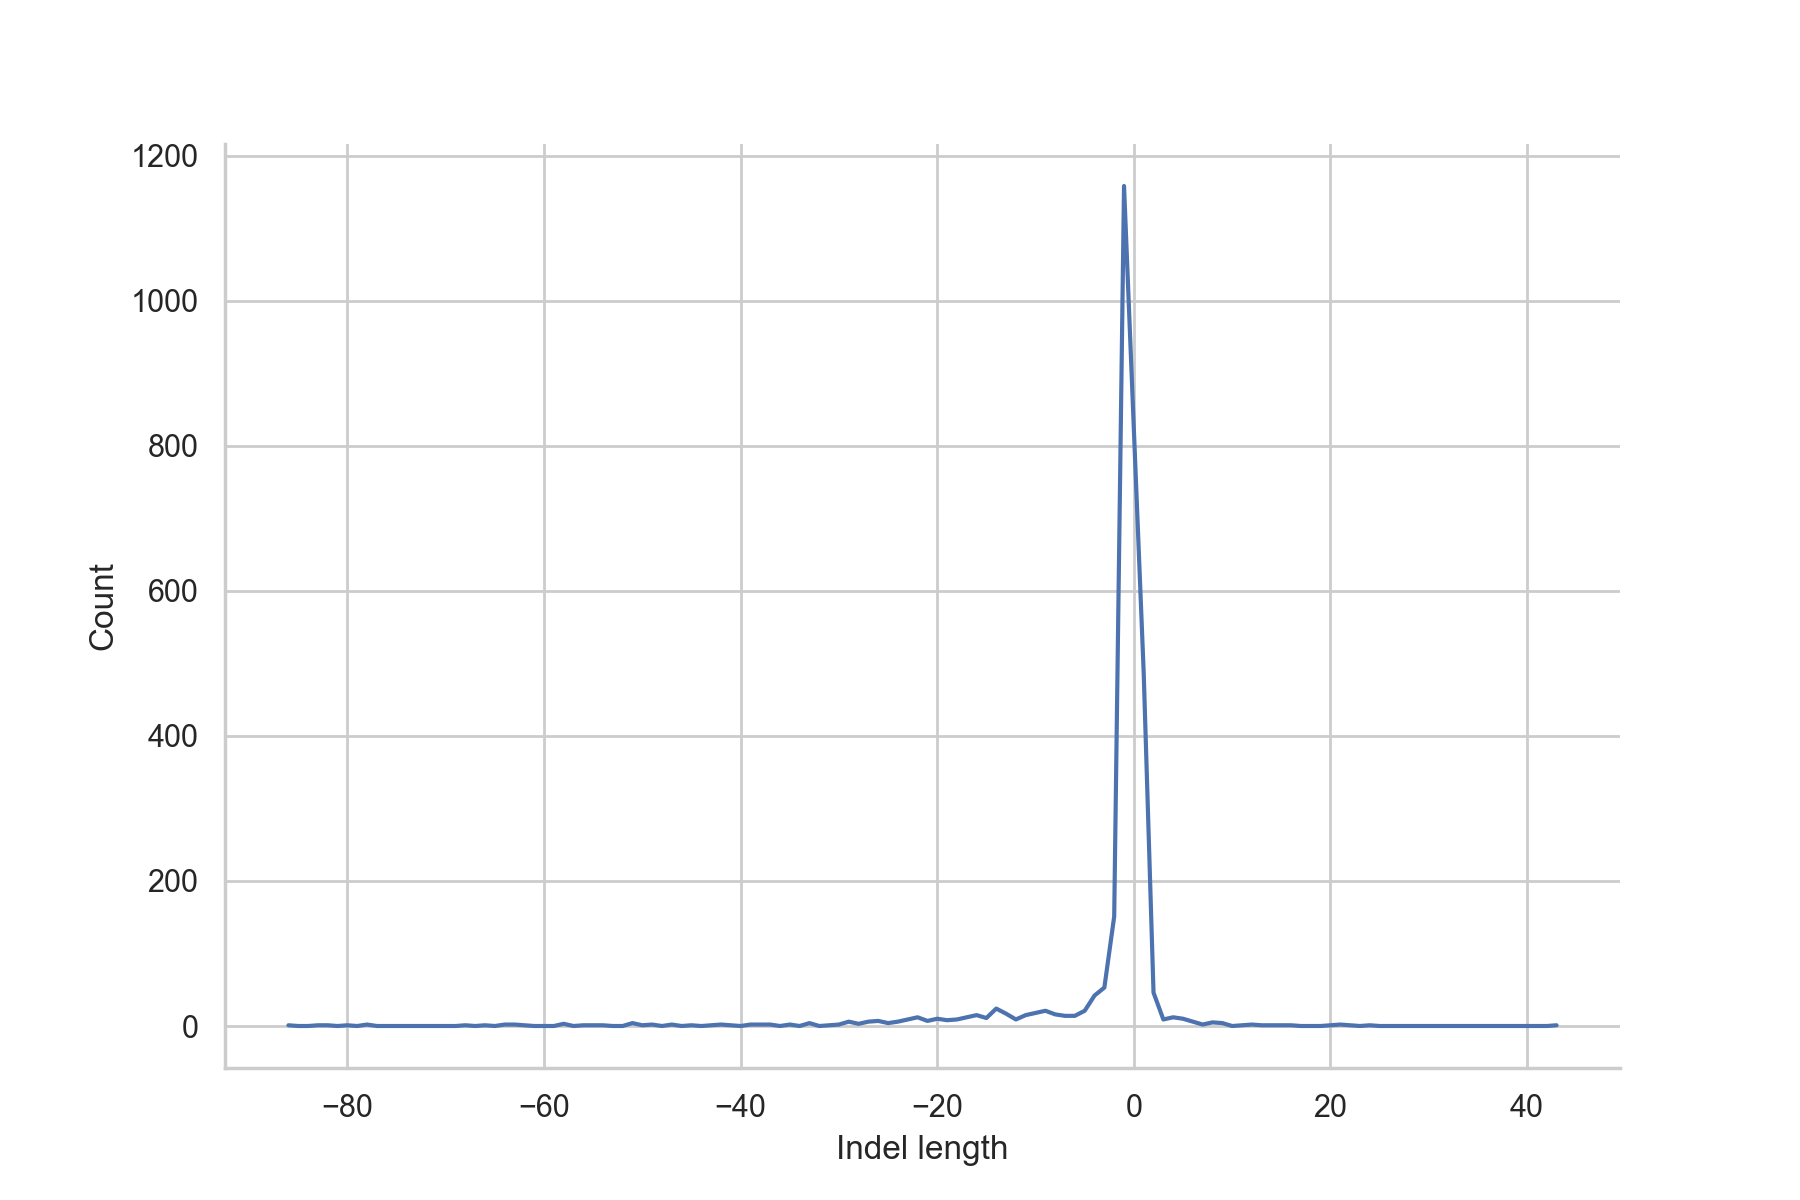

In [207]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.lineplot(x="size", y="count",
                 data=indel_stats_df.query('caller == "Truth" and Sample=="skin" and abs(size) > 0'),
                 ax=ax)
sns.despine(ax=ax)
ax.set(xlabel='Indel length')
ax.set(ylabel='Count', xlabel='Indel length')
plt.savefig("/Users/dcooke/Documents/octopus-paper/supplementary/figures/synthetic_skin_spike_indels.pdf",
            format='pdf', 
            transparent=True,
            bbox_inches='tight')

<IPython.core.display.Javascript object>


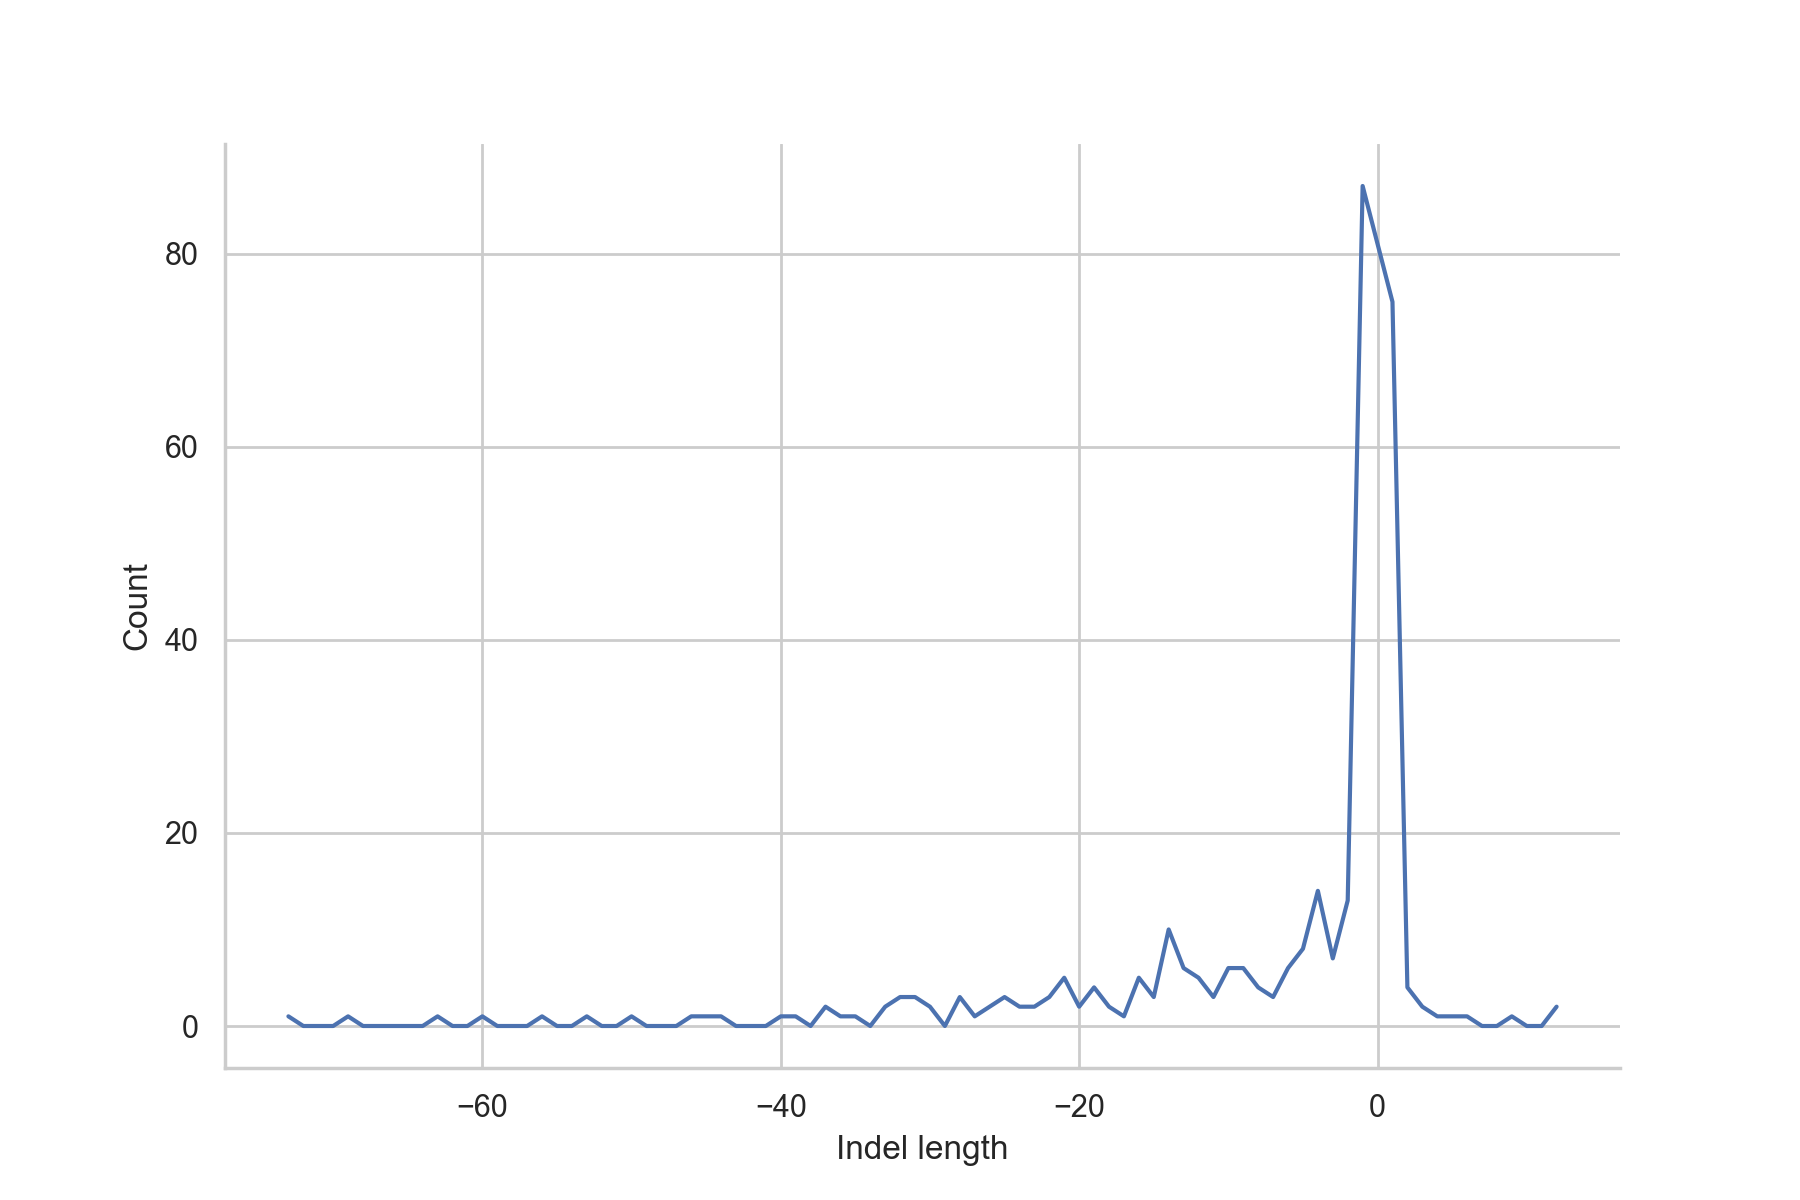

In [208]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
g = sns.lineplot(x="size", y="count",
                    data=indel_stats_df.query('caller == "Truth" and Sample=="breast" and abs(size) > 0'),
                    ax=ax)
sns.despine(ax=ax)
ax.set(xlabel='Indel length')
ax.set(ylabel='Count', xlabel='Indel length')
plt.savefig("/Users/dcooke/Documents/octopus-paper/supplementary/figures/synthetic_breast_spike_indels.pdf",
            format='pdf', 
            transparent=True,
            bbox_inches='tight')